# Multi Spacecraft Event Analysis - 2024 - March

This notebook documents the workflow to use 3DCORE for analysis of a Multi Spacecraft Event March 2024

(23-03-2024) which gave in-situ signatures on [BepiColombo](https://helioforecast.space/icmecat/ICME_BEPI_MOESTL_20240324_01), [SolO](https://helioforecast.space/icmecat/ICME_SOLO_MOESTL_20240323_01) and [STEREO-A](https://helioforecast.space/icmecat/ICME_STEREO_A_MOESTL_20240324_01). It is reported in the DONKI database [here](https://kauai.ccmc.gsfc.nasa.gov/DONKI/view/CME/29715/5).

number 10 (22-09-2023) in the line-up database giving in-situ signatures on [PSP](https://helioforecast.space/icmecat/ICME_PSP_MOESTL_20230922_01), [Wind](https://helioforecast.space/icmecat/ICME_Wind_MOESTL_20230924_01) and [STEREO-A](https://helioforecast.space/icmecat/ICME_STEREO_A_MOESTL_20230924_01) and reported in the DONKI database [here](https://kauai.ccmc.gsfc.nasa.gov/DONKI/view/CME/27043/2).

In [1]:
from pathlib import Path
import datetime
import pandas as pd

import re
import urllib

import pickle

# suppress warnings
import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.append(str(Path.cwd().parent)) 

from src.data.data_cache import get_data_cache
from src.methods.utils import get_modelkwargs_ranges
from src.methods.fitting import standard_fit, load_fit_parameters, load_ensemble
from src.methods.plotting import plot_insitu_results, plot_3d_results

cache_path = Path.cwd().parent / "cache"


###################################
# settings for plots
###################################

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
sns.set_context('paper')

insitu_colors = ['#c20078','#f97306', '#069af3']

SMALLEST_SIZE = 16
SMALL_SIZE = 20
MEDIUM_SIZE = 22
BIGGER_SIZE = 24

matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.rm'] = 'DejaVu Sans'
matplotlib.rcParams['mathtext.it'] = 'DejaVu Sans:italic'
matplotlib.rcParams['mathtext.bf'] = 'DejaVu Sans:bold'

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('axes', titlesize=BIGGER_SIZE)  # fontsize of the figure title


Kernels path loaded: /Volumes/SSDPortable/data/kernels
File names loaded
Data path loaded: /Volumes/SSDPortable/data
Data path loaded: /Volumes/SSDPortable/data


#### Data Preprocessing

We check the [CME Scoreboard](https://kauai.ccmc.gsfc.nasa.gov/CMEscoreboard/) for any suitable CME and prepare the realtime data.

In [2]:
start_date = datetime.datetime(2024,3,23).strftime('%Y-%m-%d')
end_date = datetime.datetime(2024,3,24).strftime('%Y-%m-%d')

url_donki='https://kauai.ccmc.gsfc.nasa.gov/DONKI/WS/get/CMEAnalysis?startDate='+start_date+'&endDate='+end_date+'&mostAccurateOnly=true'
try: urllib.request.urlretrieve(url_donki,cache_path / Path('DONKI.json'))
except urllib.error.URLError as e:
    print('DONKI not loaded')

donkicat = pd.read_json(cache_path / 'DONKI.json')
print(f'# CMEs between {start_date} and {end_date}: ', len(donkicat))

filtered_donki = donkicat[donkicat['associatedCMEID'].str.contains('2024-03-23T01:25:00-CME-001')] # we extract the event with the correct ID
print('# CMEs filtered: ', len(filtered_donki))

# choose correct one!

catalogevent = filtered_donki.iloc[0]

for col in donkicat.columns:
    print(str(col) +': '+ str(catalogevent[col]))

dateFormat = "%Y-%m-%dT%H:%MZ"
cataloglaunchtime = datetime.datetime.strptime(catalogevent['time21_5'], dateFormat)

# CMEs between 2024-03-23 and 2024-03-24:  7
# CMEs filtered:  1
time21_5: 2024-03-23T03:19Z
latitude: 22
longitude: 2
halfAngle: 41
speed: 1613
type: O
isMostAccurate: True
associatedCMEID: 2024-03-23T01:25:00-CME-001
associatedCMEstartTime: 2024-03-23T01:25Z
note: Approximate measurement which follows the brighter bulk portion of this complex-shape event. Measured parameters are based on the source location and the best fit in SOHO LASCO C3 imagery, however the center of the elongated source eruption is not certain. There is a data gap in STEREO A COR2 imagery during this event so there was no stereoscopic viewpoint available to confirm the measured parameters. The half width of this CME is also not certain.
associatedCMELink: https://kauai.ccmc.gsfc.nasa.gov/DONKI/view/CME/29715/-1
catalog: M2M_CATALOG
featureCode: LE
dataLevel: 0
measurementTechnique: SWPC_CAT
imageType: running difference
tilt: nan
minorHalfWidth: nan
speedMeasuredAtHeight: 27.6
submissionTime: 2024-03-23T19:02Z
v

#### Solar Orbiter

In [3]:
idd_solo = 'ICME_SOLO_MOESTL_20240323_01' # this is the ID of the event we want to analyze

# reduce delta_t_days to reduce computation time during ensemble generation
data_cache_solo = get_data_cache(idd_solo, mean_hours=24, delta_t_days = 3) # mean_hours is the number of hours before the event to calculate the mean solar wind speed

output_path = Path.cwd().parent / "output"
output_folder = output_path / data_cache_solo.idd

Loading data from cache for ICME_SOLO_MOESTL_20240323_01


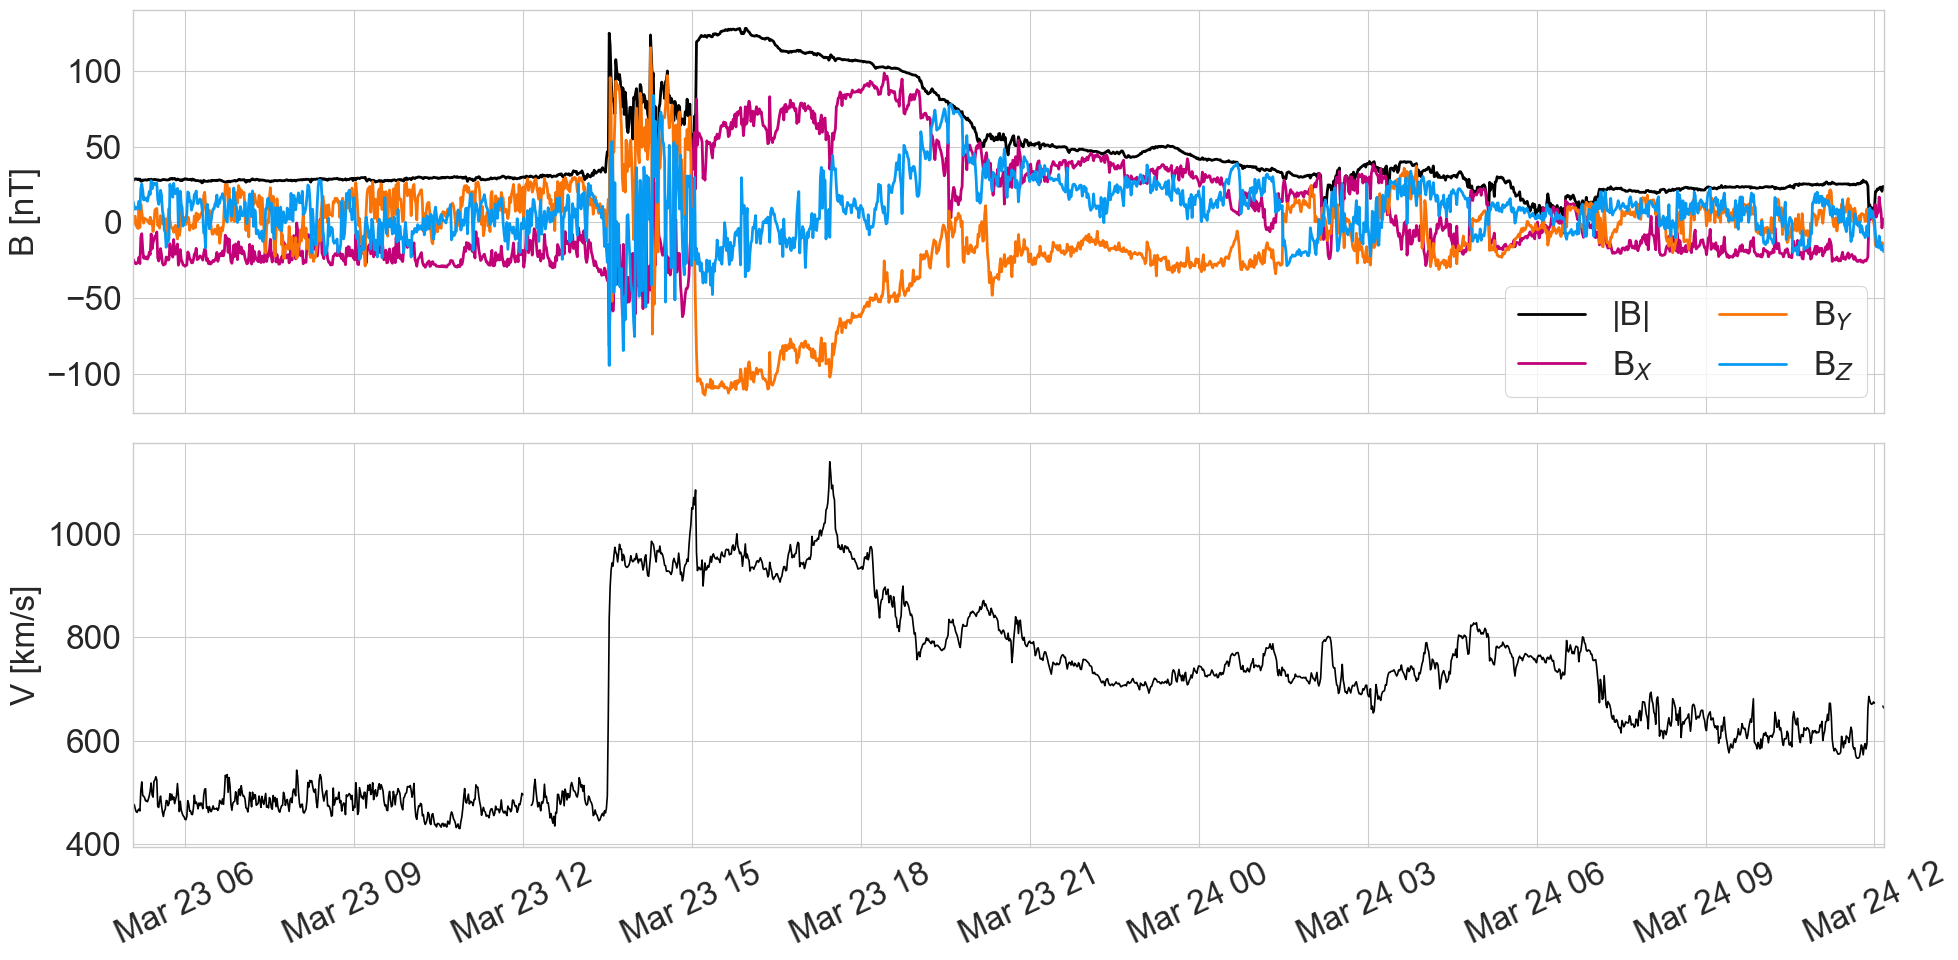

In [4]:
save_quick_insitu_plot = True

fig, axes = data_cache_solo.quick_insitu_plot(
    reference_frame="HEEQ", 
    delta_time_hours=10, 
    colors=insitu_colors, 
    figsize=(20,10),
    fontsize=BIGGER_SIZE,
    lw_insitu=2
)

if save_quick_insitu_plot:
    output_folder.mkdir(parents=True, exist_ok=True)
    fig.savefig(output_folder / f"{data_cache_solo.idd}_insitu_quicklook.png", dpi=200)

fig.show()

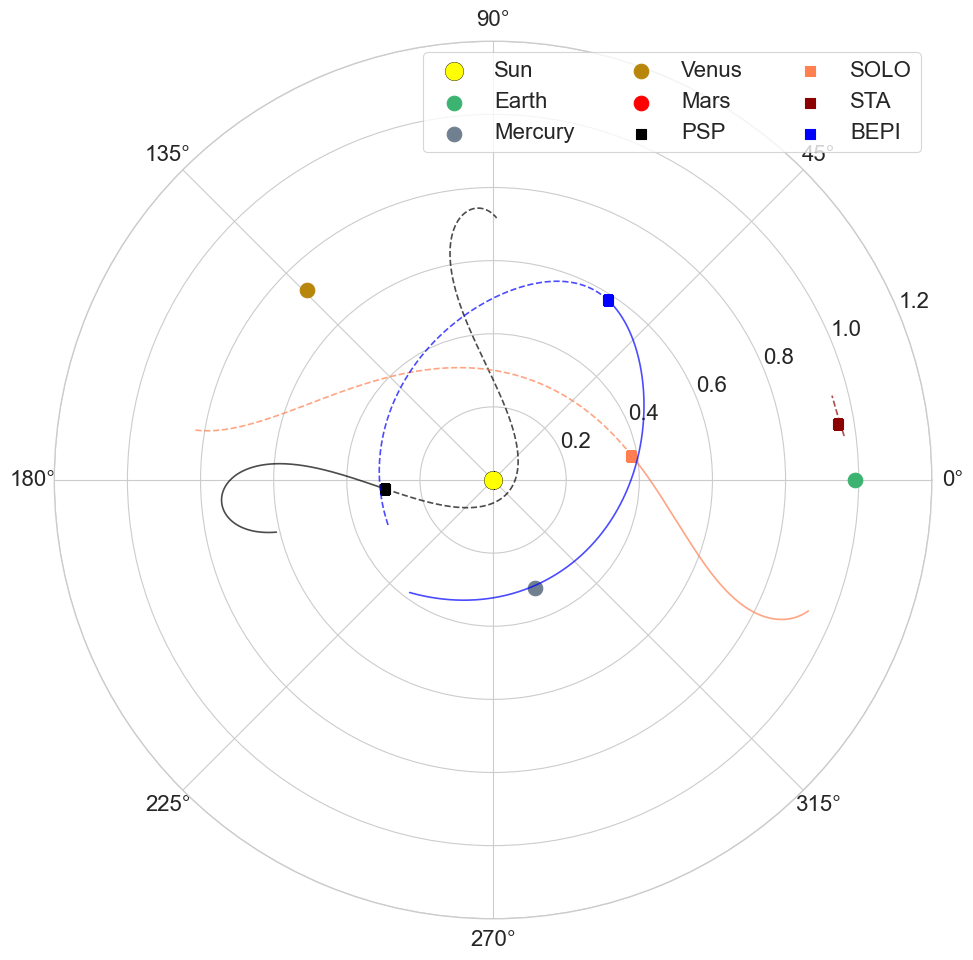

In [5]:
save_quick_positions_plot = True

fig, ax = data_cache_solo.quick_positions_plot(
    fontsize=SMALLEST_SIZE,
    figsize=(20,10)
)

if save_quick_positions_plot:
    output_folder.mkdir(parents=True, exist_ok=True)
    fig.savefig(output_folder / f"{data_cache_solo.idd}_positions_quicklook.png", dpi=200)

fig.show()

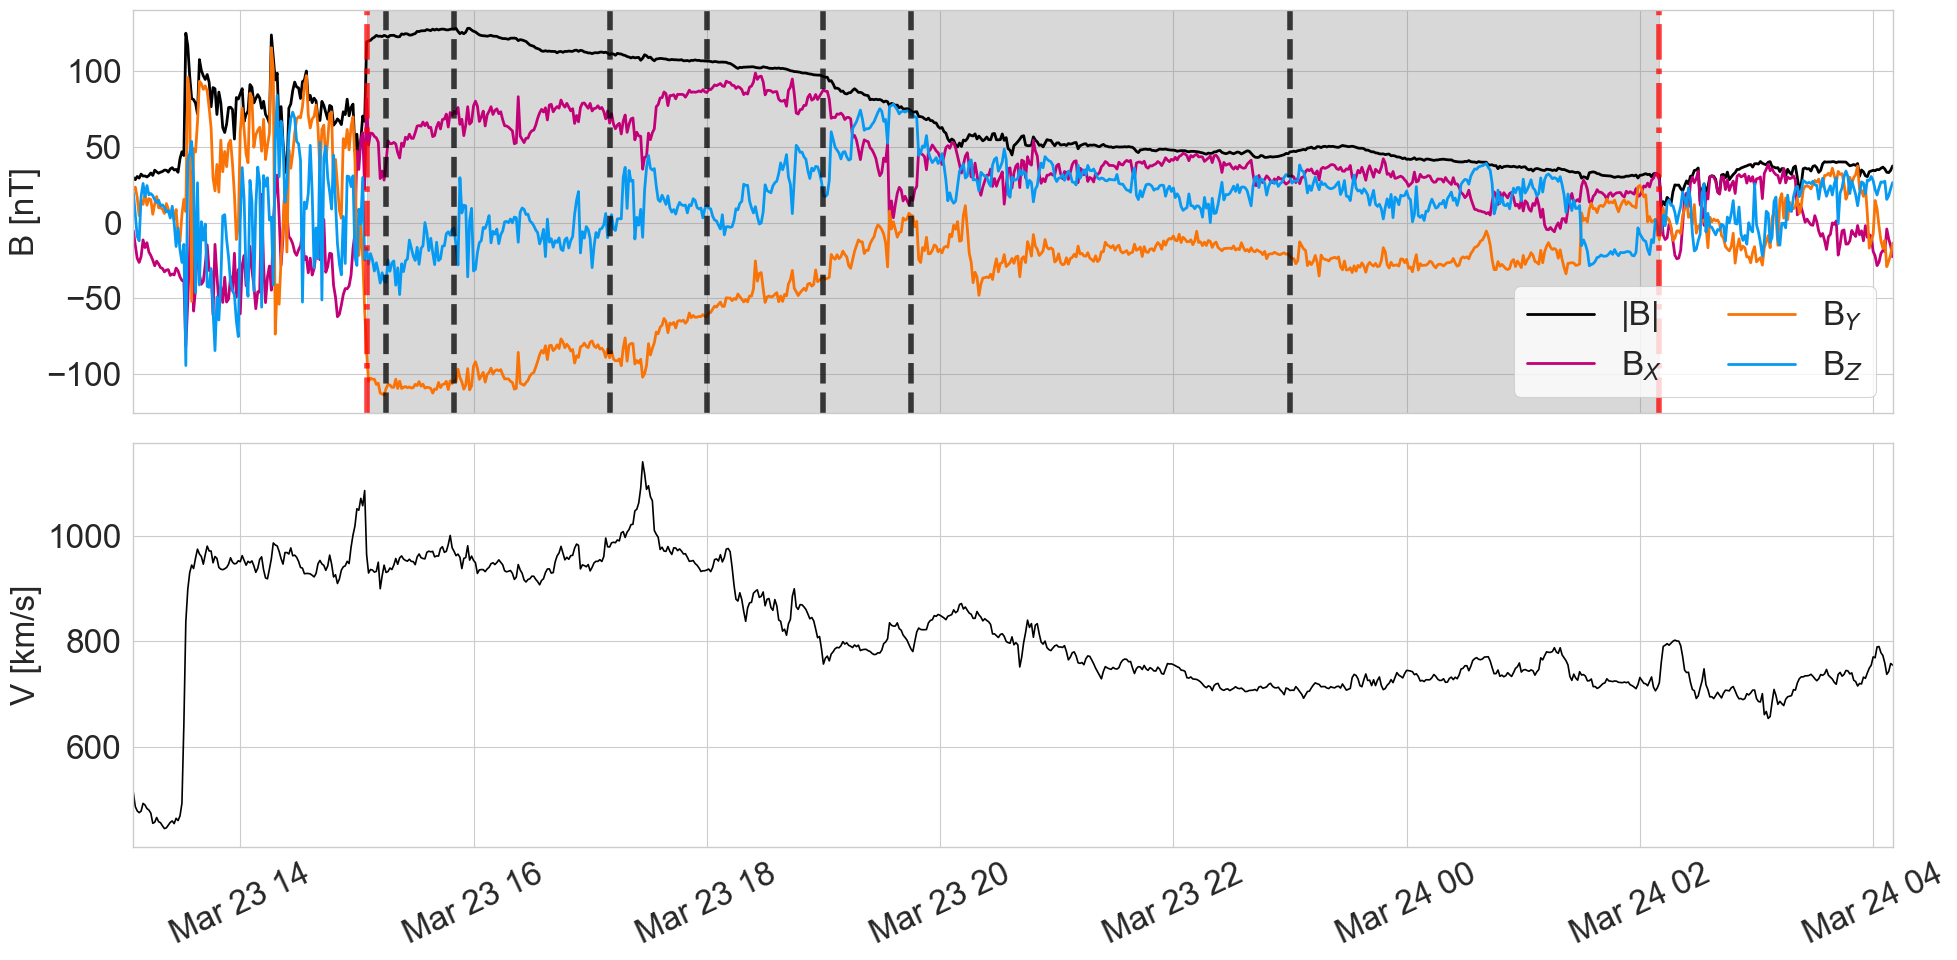

In [6]:
t_launch = cataloglaunchtime.replace(tzinfo=None) # choose launch time

t_s = data_cache_solo.mo_begin # will be set to that automatically if None
t_e = data_cache_solo.endtime # will be set to that automatically if None


t_fit =[
     datetime.datetime(2024, 3, 23, 15, 15, tzinfo=datetime.timezone.utc),
     datetime.datetime(2024, 3, 23, 15, 50, tzinfo=datetime.timezone.utc),
     datetime.datetime(2024, 3, 23, 17, 10, tzinfo=datetime.timezone.utc),
     datetime.datetime(2024, 3, 23, 18, 00, tzinfo=datetime.timezone.utc),
     datetime.datetime(2024, 3, 23, 19, 00, tzinfo=datetime.timezone.utc),
     datetime.datetime(2024, 3, 23, 19, 45, tzinfo=datetime.timezone.utc),
     datetime.datetime(2024, 3, 23, 23, 00, tzinfo=datetime.timezone.utc),
]

save_quick_fitting_points_plot = True

fig, axes = data_cache_solo.check_fitting_points(
    t_s, 
    t_e, 
    t_fit, 
    colors=insitu_colors, 
    figsize=(20,10),
    fontsize=BIGGER_SIZE,
    lw_insitu=2,
    lw_fitpts=4
)

if save_quick_fitting_points_plot:
    output_folder.mkdir(parents=True, exist_ok=True)
    fig.savefig(output_folder / f"{data_cache_solo.idd}_insitu_fittingpoints.png", dpi=200)

In [7]:
longitude_delta = 40
latitude_delta = 30

speed_delta = 100

bg_v_delta = 100
bg_v = data_cache_solo.v_mean_before_event


modelstatevar_ranges = [
    int(2**18) # ensemblesize
    ] + [
        [catalogevent['longitude'] - longitude_delta,catalogevent['longitude']+longitude_delta], # Longitude (HEEQ)
        [catalogevent['latitude'] - latitude_delta,catalogevent['latitude'] +latitude_delta], # Latitude (HEEQ)
        [0.,360.], # Inclination
        [0.05,0.35], # Diameter 1 AU 
        [1.,3.5], # Aspect Ratio  
        [21.5,21.5], # Launch Radius
        [catalogevent['speed'] - speed_delta, catalogevent['speed'] + speed_delta], # Launch Velocity
        [1.,2.0], # Expansion Rate
        [0.20,3.00], # Background Drag
        [bg_v - bg_v_delta, bg_v + bg_v_delta], # Background Velocity
        [-250.,250.], # T_Factor
        [1.,2.], # Magnetic Decay Rate
        [5.,65.], # Magnetic Field Strength 1 AU
    ]

modelkwargs = get_modelkwargs_ranges(modelstatevar_ranges)

multiprocessing = True

njobs = 4

itermin = 12
itermax = 15

n_particles = 512

In [8]:
rerun_fitting = False

fit_number = "last" # "last" or integer

if rerun_fitting:
    extra_args = standard_fit(
        data_cache = data_cache_solo,
        t_launch=t_launch,
        t_s=t_s,
        t_e=t_e,
        t_fit=t_fit,
        model_kwargs=modelkwargs,
        njobs=njobs,
        multiprocessing=multiprocessing,
        itermin=itermin,
        itermax=itermax,
        n_particles=n_particles,
    )

if fit_number == "last":
    fit_files = [
        f for f in output_folder.glob("*.pickle")
        if re.match(r"^\d{2}\.pickle$", f.name)
    ]
    fit_files.sort()

    if fit_files == []:
        print(f"No fitting results found, set rerun_fitting to True")
    else:
        fit_file = fit_files[-1]
else:
    fit_file = output_folder / f"{fit_number:02d}.pickle"

try:
    with open(fit_file, "rb") as fh:
        extra_args = pickle.load(fh)

    print("Loaded fit from file: ", fit_file)
except:
    print(f"Error loading fit results")



Loaded fit from file:  /Users/hannahruedisser/3DCORE-ASWO/output/ICME_SOLO_MOESTL_20240323_01/03.pickle


In [9]:
ensemble_data_solo = load_ensemble(output_folder= output_folder, fit_file=fit_file, data_cache=data_cache_solo)

Loaded ensemble from /Users/hannahruedisser/3DCORE-ASWO/output/ICME_SOLO_MOESTL_20240323_01/ensemble_03.pickle


In [10]:
results_df_solo, stats_df_solo = load_fit_parameters(fit_file=fit_file, t0=t_launch)

In [11]:
results_df_solo.head()

Index  RMSE Ɛ  Longitude  Latitude  Inclination  Diameter 1 AU  \
0     0    0.78      -1.38      1.85       305.16           0.34   
1     1    0.77      -7.28      1.94       304.65           0.32   
2     2    0.69     -13.27     12.24       315.64           0.32   
3     3    0.74      -8.72      2.44       326.78           0.34   
4     4    0.78     -10.53      7.01       315.72           0.34   

   Aspect Ratio  Launch Radius  Launch Velocity  T_Factor  Expansion Rate  \
0          1.66           21.5          1657.57    -97.90            1.09   
1          3.34           21.5          1591.55    -18.23            1.13   
2          2.63           21.5          1617.39    -38.03            1.16   
3          2.99           21.5          1668.39    -14.71            1.18   
4          3.47           21.5          1534.79    -51.12            1.02   

   Magnetic Decay Rate  Magnetic Field Strength 1 AU  Background Drag  \
0                 1.42                         40.57             0.63   
1                 1.51                         17.46             0.40   
2                 1.35                         26.97             0.34   
3                 1.36                         16.63             0.40   
4                 1.94                         10.34             0.34   

   Background Velocity  Number of Twists       Launch Time  
0               530.87            -11.55  2024-03-23 03:19  
1               414.64             -1.24  2024-03-23 03:19  
2               586.04             -3.17  2024-03-23 03:19  
3               429.20             -1.10  2024-03-23 03:19  
4               508.07             -3.38  2024-03-23 03:19

In [12]:
stats_df_solo.head()

Index  RMSE Ɛ  Longitude  Latitude  Inclination  \
0                Mean    0.72      -6.92      2.09       319.37   
1  Standard Deviation    0.05       7.06      6.54        40.33   
2              Median     NaN        NaN       NaN          NaN   
3             Minimum    0.45     -27.14     -7.96         0.36   
4             Maximum    0.78      17.51     24.26       358.24   

   Diameter 1 AU  Aspect Ratio  Launch Radius  Launch Velocity  T_Factor  \
0           0.33          2.45           21.5          1618.87    -31.96   
1           0.02          0.62            0.0            53.89     24.90   
2            NaN           NaN            NaN              NaN       NaN   
3           0.28          1.01           21.5          1513.06   -192.76   
4           0.35          3.49           21.5          1712.29     12.84   

   Expansion Rate  Magnetic Decay Rate  Magnetic Field Strength 1 AU  \
0            1.12                 1.46                         25.17   
1            0.09                 0.26                          9.51   
2             NaN                  NaN                           NaN   
3            1.00                 1.00                          8.80   
4            1.39                 2.00                         63.12   

   Background Drag  Background Velocity  Number of Twists       Launch Time  
0             0.49               514.64             -3.01  2024-03-23 03:19  
1             0.15                52.68              2.65  2024-03-23 03:19  
2              NaN                  NaN               NaN  2024-03-23 03:19  
3             0.20               407.26            -20.48  2024-03-23 03:19  
4             1.02               604.71              1.48  2024-03-23 03:19

In [13]:
max_col_width = max(len(str(col)) for col in stats_df_solo.columns[2:-1])

for col in stats_df_solo.columns[1:-1]:
    print('{:<{}}{:>20} +/- {:>20}'.format(str(col) + ':', max_col_width + 1, str(stats_df_solo[col][0]), str(stats_df_solo[col][1])))

RMSE Ɛ:                                      0.72 +/-                 0.05
Longitude:                                  -6.92 +/-                 7.06
Latitude:                                    2.09 +/-                 6.54
Inclination:                               319.37 +/-                40.33
Diameter 1 AU:                               0.33 +/-                 0.02
Aspect Ratio:                                2.45 +/-                 0.62
Launch Radius:                               21.5 +/-                  0.0
Launch Velocity:                          1618.87 +/-                53.89
T_Factor:                                  -31.96 +/-                 24.9
Expansion Rate:                              1.12 +/-                 0.09
Magnetic Decay Rate:                         1.46 +/-                 0.26
Magnetic Field Strength 1 AU:               25.17 +/-                 9.51
Background Drag:                             0.49 +/-                 0.15
Background Velocity:     

In [14]:
row_solo= results_df_solo.iloc[results_df_solo['RMSE Ɛ'].idxmin()] # extract parameters from minimum eps row


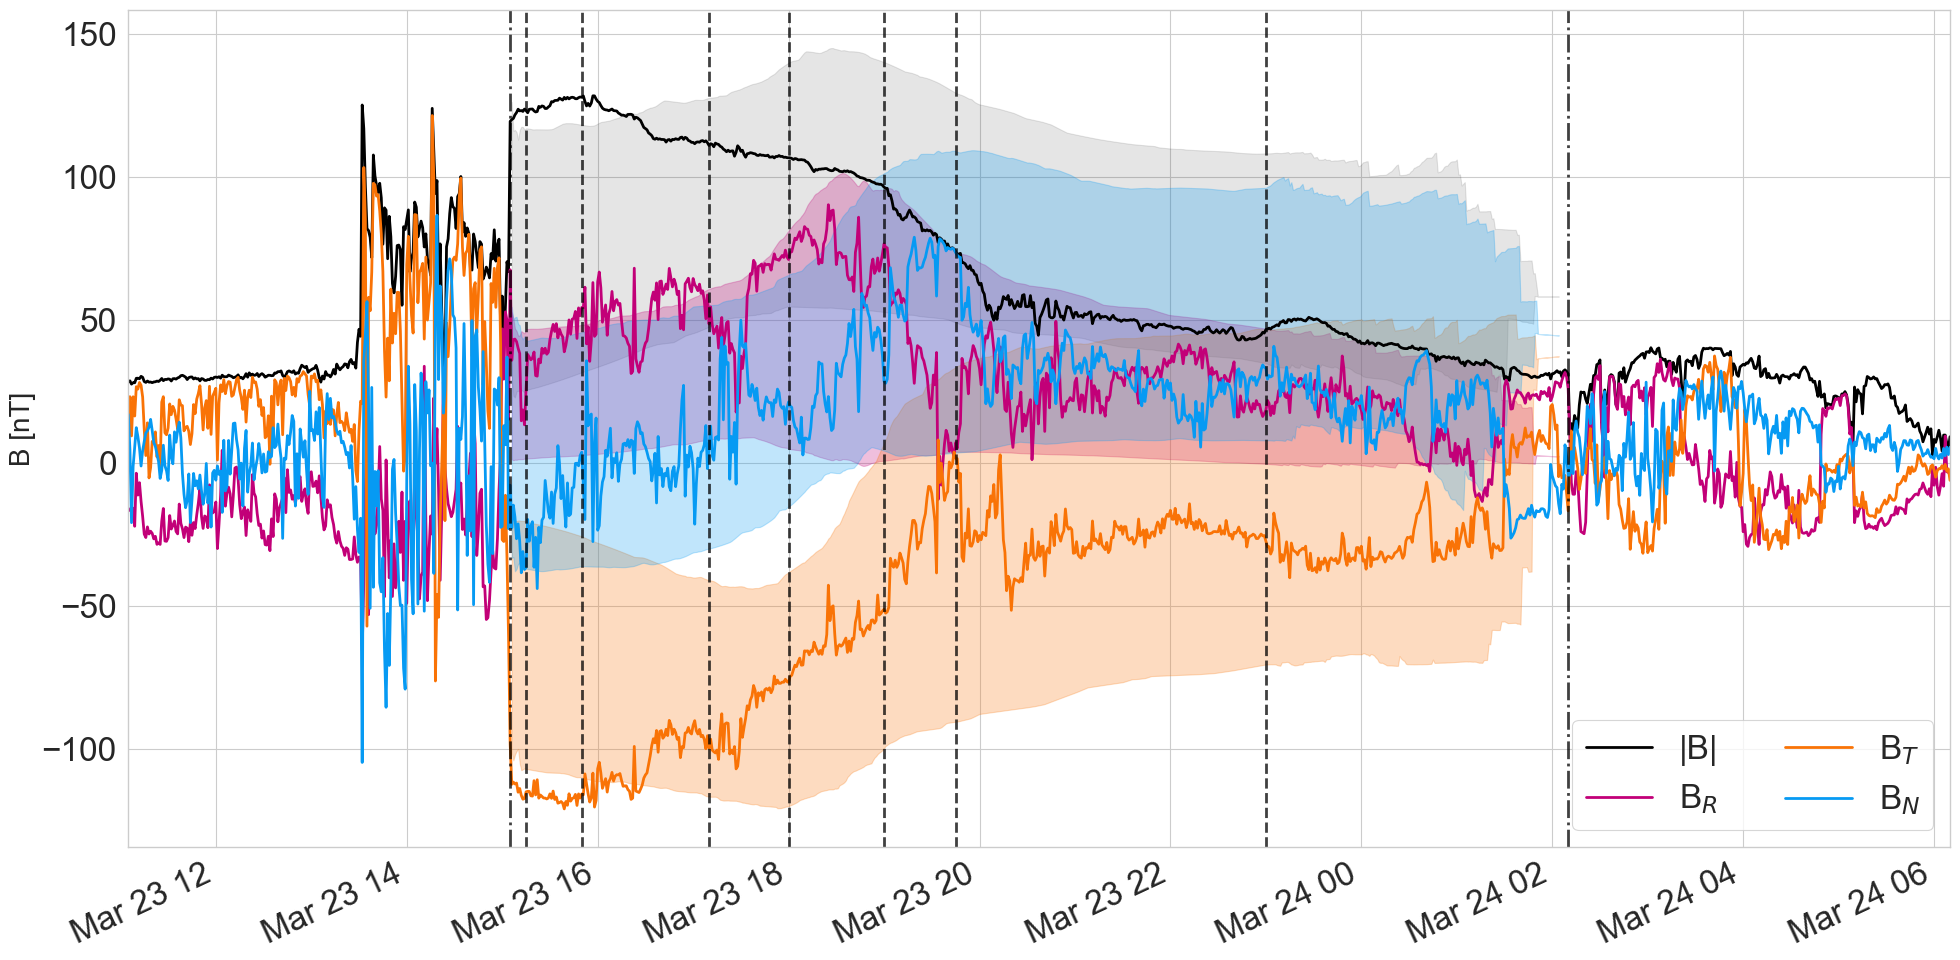

In [15]:
save_quick_results_plot = True

if t_s is not None and t_e is not None:
    insitu_start = t_s - datetime.timedelta(hours=4) # these can be set instead of delta_time_hours
    insitu_end = t_e + datetime.timedelta(hours=4) # these can be set instead of delta_time_hours
else:
    insitu_start = None
    insitu_end = None


fig, ax = plot_insitu_results(
    data_cache=data_cache_solo,
    reference_frame="RTN",
    delta_time_hours=2,
    insitu_start=insitu_start,
    insitu_end=insitu_end,
    t_s = t_s, # set to None if not to be plotted
    t_e = t_e, # set to None if not to be plotted
    t_fit = t_fit, # set to None if not to be plotted
    colors = insitu_colors,
    figsize=(20,10),
    fontsize=BIGGER_SIZE,
    lw_insitu=2,
    lw_best=3,
    lw_mean=3,
    lw_fitpts=2,
    ensemble_data=ensemble_data_solo,
)

if save_quick_results_plot:
    output_folder.mkdir(parents=True, exist_ok=True)
    fig.savefig(output_folder / f"{data_cache_solo.idd}_insitu_fitresults.png", dpi=200)

In [16]:
# Set new elements for data_cache so they can be used later on

data_cache_solo.row = row_solo

#### STEREO-A

In [17]:
idd_sta = 'ICME_STEREO_A_MOESTL_20240324_01' # this is the ID of the event we want to analyze

# reduce delta_t_days to reduce computation time during ensemble generation
data_cache_sta = get_data_cache(idd_sta, mean_hours=24, delta_t_days = 3) # mean_hours is the number of hours before the event to calculate the mean solar wind speed

output_path = Path.cwd().parent / "output"
output_folder = output_path / data_cache_sta.idd

Loading data from cache for ICME_STEREO_A_MOESTL_20240324_01


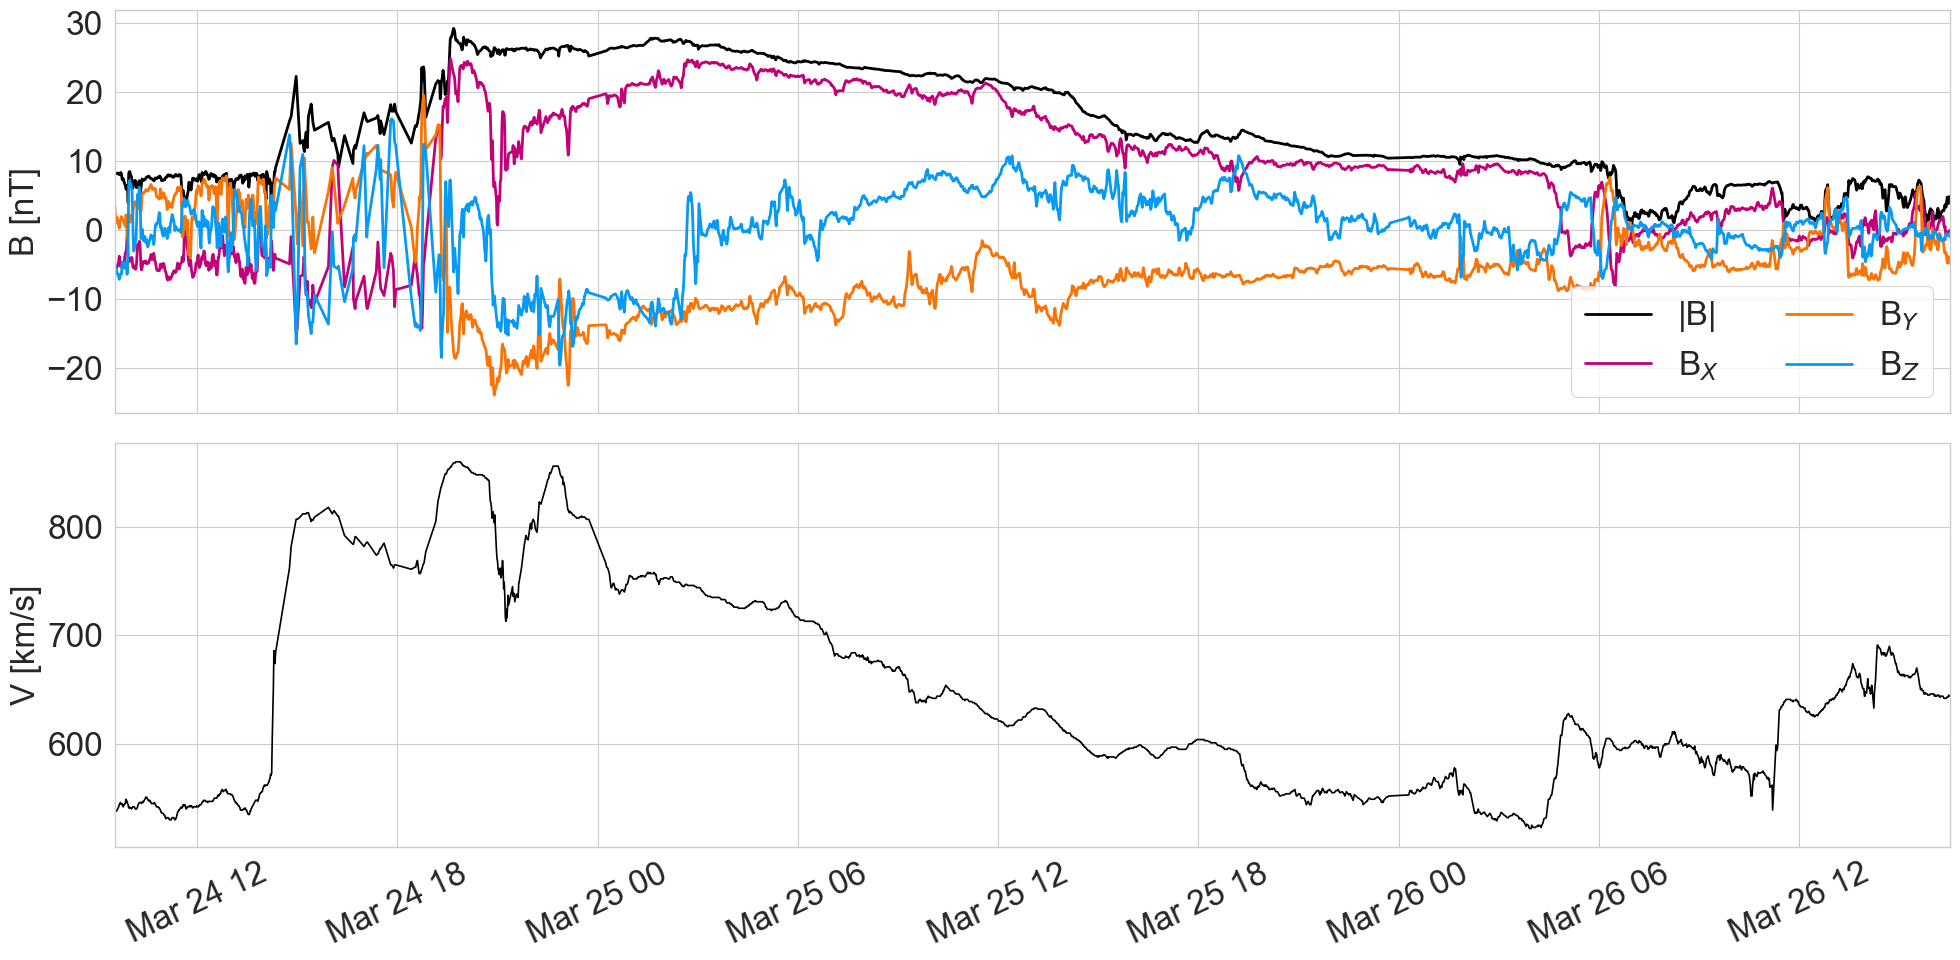

In [18]:
fig, axes = data_cache_sta.quick_insitu_plot(
    reference_frame="HEEQ", 
    delta_time_hours=10, 
    colors=insitu_colors, 
    figsize=(20,10),
    fontsize=BIGGER_SIZE,
    lw_insitu=2
)

if save_quick_insitu_plot:
    output_folder.mkdir(parents=True, exist_ok=True)
    fig.savefig(output_folder / f"{data_cache_sta.idd}_insitu_quicklook.png", dpi=200)

fig.show()

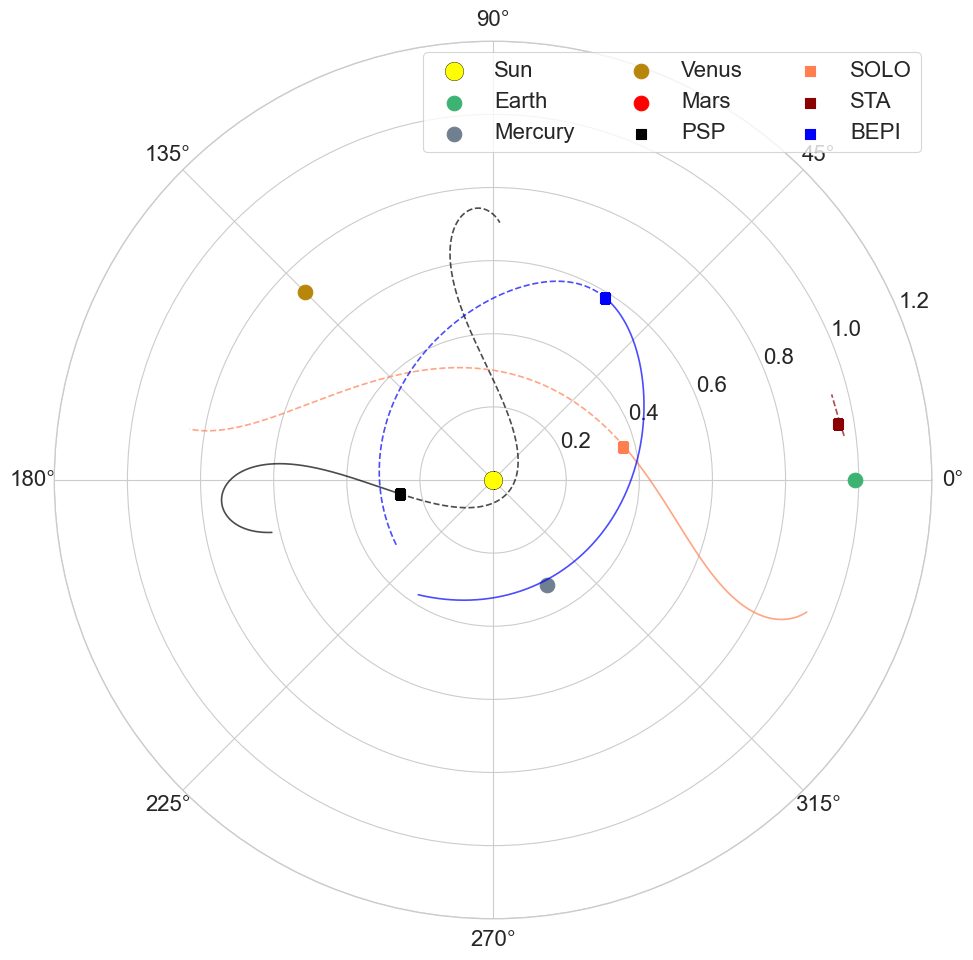

In [19]:
fig, ax = data_cache_sta.quick_positions_plot(
    fontsize=SMALLEST_SIZE,
    figsize=(20,10)
)

if save_quick_positions_plot:
    output_folder.mkdir(parents=True, exist_ok=True)
    fig.savefig(output_folder / f"{data_cache_sta.idd}_positions_quicklook.png", dpi=200)

fig.show()

Fitting points not given, setting to 4 equidistant points between 2024-03-24 19:32:00 and 2024-03-26 06:31:00:


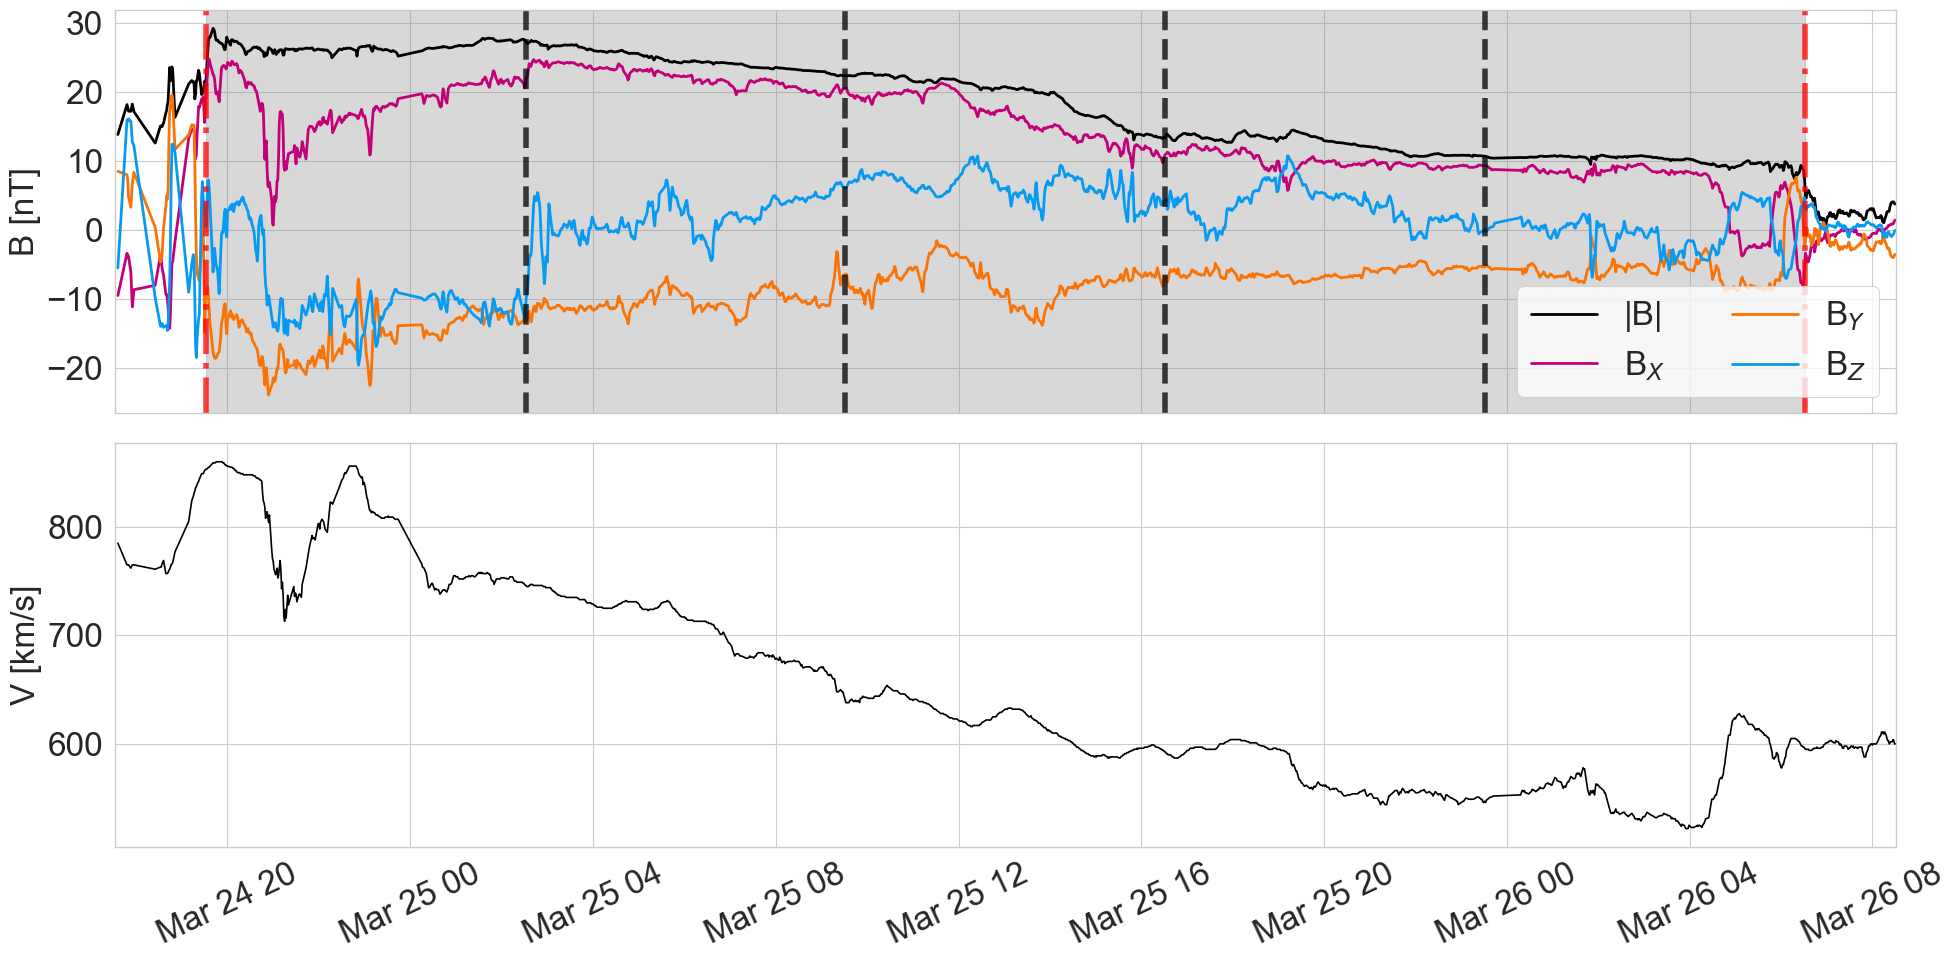

In [20]:
t_launch = cataloglaunchtime.replace(tzinfo=None) # choose launch time

t_s = data_cache_sta.mo_begin # will be set to that automatically if None
t_e = data_cache_sta.endtime # will be set to that automatically if None


t_fit = None


fig, axes = data_cache_sta.check_fitting_points(
    t_s, 
    t_e, 
    t_fit, 
    colors=insitu_colors, 
    figsize=(20,10),
    fontsize=BIGGER_SIZE,
    lw_insitu=2,
    lw_fitpts=4
)

if save_quick_fitting_points_plot:
    output_folder.mkdir(parents=True, exist_ok=True)
    fig.savefig(output_folder / f"{data_cache_sta.idd}_insitu_fittingpoints.png", dpi=200)

In [21]:
longitude_delta = 40
latitude_delta = 30

speed_delta = 100

bg_v_delta = 100
bg_v = data_cache_sta.v_mean_before_event


modelstatevar_ranges = [
    int(2**18) # ensemblesize
    ] + [
        [catalogevent['longitude'] - longitude_delta,catalogevent['longitude']+longitude_delta], # Longitude (HEEQ)
        [catalogevent['latitude'] - latitude_delta,catalogevent['latitude'] +latitude_delta], # Latitude (HEEQ)
        [0.,360.], # Inclination
        [0.05,0.35], # Diameter 1 AU 
        [1.,3.5], # Aspect Ratio  
        [21.5,21.5], # Launch Radius
        [catalogevent['speed'] - speed_delta, catalogevent['speed'] + speed_delta], # Launch Velocity
        [1.,2.0], # Expansion Rate
        [0.20,3.00], # Background Drag
        [bg_v - bg_v_delta, bg_v + bg_v_delta], # Background Velocity
        [-250.,250.], # T_Factor
        [1.,2.], # Magnetic Decay Rate
        [5.,65.], # Magnetic Field Strength 1 AU
    ]

modelkwargs = get_modelkwargs_ranges(modelstatevar_ranges)

multiprocessing = True

njobs = 4

itermin = 12
itermax = 15

n_particles = 512

In [22]:
rerun_fitting = False

fit_number = "last" # "last" or integer

if rerun_fitting:
    extra_args = standard_fit(
        data_cache = data_cache_sta,
        t_launch=t_launch,
        t_s=t_s,
        t_e=t_e,
        t_fit=t_fit,
        model_kwargs=modelkwargs,
        njobs=njobs,
        multiprocessing=multiprocessing,
        itermin=itermin,
        itermax=itermax,
        n_particles=n_particles,
    )

if fit_number == "last":
    fit_files = [
        f for f in output_folder.glob("*.pickle")
        if re.match(r"^\d{2}\.pickle$", f.name)
    ]
    fit_files.sort()

    if fit_files == []:
        print(f"No fitting results found, set rerun_fitting to True")
    else:
        fit_file = fit_files[-1]
else:
    fit_file = output_folder / f"{fit_number:02d}.pickle"

try:
    with open(fit_file, "rb") as fh:
        extra_args = pickle.load(fh)

    print("Loaded fit from file: ", fit_file)
except:
    print(f"Error loading fit results")

Loaded fit from file:  /Users/hannahruedisser/3DCORE-ASWO/output/ICME_STEREO_A_MOESTL_20240324_01/01.pickle


In [23]:
ensemble_data_sta = load_ensemble(output_folder= output_folder, fit_file=fit_file, data_cache=data_cache_sta)

Loaded ensemble from /Users/hannahruedisser/3DCORE-ASWO/output/ICME_STEREO_A_MOESTL_20240324_01/ensemble_01.pickle


In [24]:
results_df_sta, stats_df_sta = load_fit_parameters(fit_file=fit_file, t0=t_launch)

In [25]:
results_df_sta.head()

Index  RMSE Ɛ  Longitude  Latitude  Inclination  Diameter 1 AU  \
0     0    1.14      19.76     18.92       256.75           0.25   
1     1    1.13      18.02     -0.22       331.86           0.31   
2     2    1.03     -13.49     -1.91       301.15           0.28   
3     3    1.12       4.78     -7.43         2.75           0.22   
4     4    1.10      25.05      5.89       108.24           0.32   

   Aspect Ratio  Launch Radius  Launch Velocity  T_Factor  Expansion Rate  \
0          1.53           21.5          1659.22    225.43            1.44   
1          1.67           21.5          1569.26    248.65            1.03   
2          2.19           21.5          1632.98    -44.92            1.64   
3          2.45           21.5          1643.10   -208.04            1.75   
4          2.02           21.5          1577.94    -56.31            1.65   

   Magnetic Decay Rate  Magnetic Field Strength 1 AU  Background Drag  \
0                 1.21                         41.84             0.39   
1                 1.89                         33.94             0.35   
2                 1.07                         13.33             0.25   
3                 1.75                          7.46             0.39   
4                 1.80                         32.23             0.31   

   Background Velocity  Number of Twists       Launch Time  
0               552.35             28.05  2024-03-23 03:19  
1               472.38             29.18  2024-03-23 03:19  
2               412.21             -4.32  2024-03-23 03:19  
3               437.33            -18.40  2024-03-23 03:19  
4               499.63             -5.77  2024-03-23 03:19

In [26]:
stats_df_sta.head()

Index  RMSE Ɛ  Longitude  Latitude  Inclination  \
0                Mean    1.08       7.30      2.87       222.02   
1  Standard Deviation    0.06      14.58      6.91       120.81   
2              Median     NaN        NaN       NaN          NaN   
3             Minimum    0.77     -24.62     -7.97         0.16   
4             Maximum    1.14      40.23     24.84       359.99   

   Diameter 1 AU  Aspect Ratio  Launch Radius  Launch Velocity  T_Factor  \
0           0.28          2.22           21.5          1617.38      8.62   
1           0.04          0.71            0.0            55.02    142.44   
2            NaN           NaN            NaN              NaN       NaN   
3           0.18          1.01           21.5          1513.71   -247.98   
4           0.35          3.50           21.5          1712.92    249.17   

   Expansion Rate  Magnetic Decay Rate  Magnetic Field Strength 1 AU  \
0            1.45                 1.53                         29.49   
1            0.27                 0.27                         15.75   
2             NaN                  NaN                           NaN   
3            1.00                 1.00                          5.02   
4            1.99                 2.00                         64.13   

   Background Drag  Background Velocity  Number of Twists       Launch Time  
0             0.37               503.10              1.05  2024-03-23 03:19  
1             0.11                49.06             14.82  2024-03-23 03:19  
2              NaN                  NaN               NaN  2024-03-23 03:19  
3             0.20               375.42            -32.90  2024-03-23 03:19  
4             0.85               574.99             37.35  2024-03-23 03:19

In [27]:
max_col_width = max(len(str(col)) for col in stats_df_sta.columns[2:-1])

for col in stats_df_sta.columns[1:-1]:
    print('{:<{}}{:>20} +/- {:>20}'.format(str(col) + ':', max_col_width + 1, str(stats_df_sta[col][0]), str(stats_df_sta[col][1])))

RMSE Ɛ:                                      1.08 +/-                 0.06
Longitude:                                    7.3 +/-                14.58
Latitude:                                    2.87 +/-                 6.91
Inclination:                               222.02 +/-               120.81
Diameter 1 AU:                               0.28 +/-                 0.04
Aspect Ratio:                                2.22 +/-                 0.71
Launch Radius:                               21.5 +/-                  0.0
Launch Velocity:                          1617.38 +/-                55.02
T_Factor:                                    8.62 +/-               142.44
Expansion Rate:                              1.45 +/-                 0.27
Magnetic Decay Rate:                         1.53 +/-                 0.27
Magnetic Field Strength 1 AU:               29.49 +/-                15.75
Background Drag:                             0.37 +/-                 0.11
Background Velocity:     

In [28]:
row_sta= results_df_sta.iloc[results_df_sta['RMSE Ɛ'].idxmin()] # extract parameters from minimum eps row


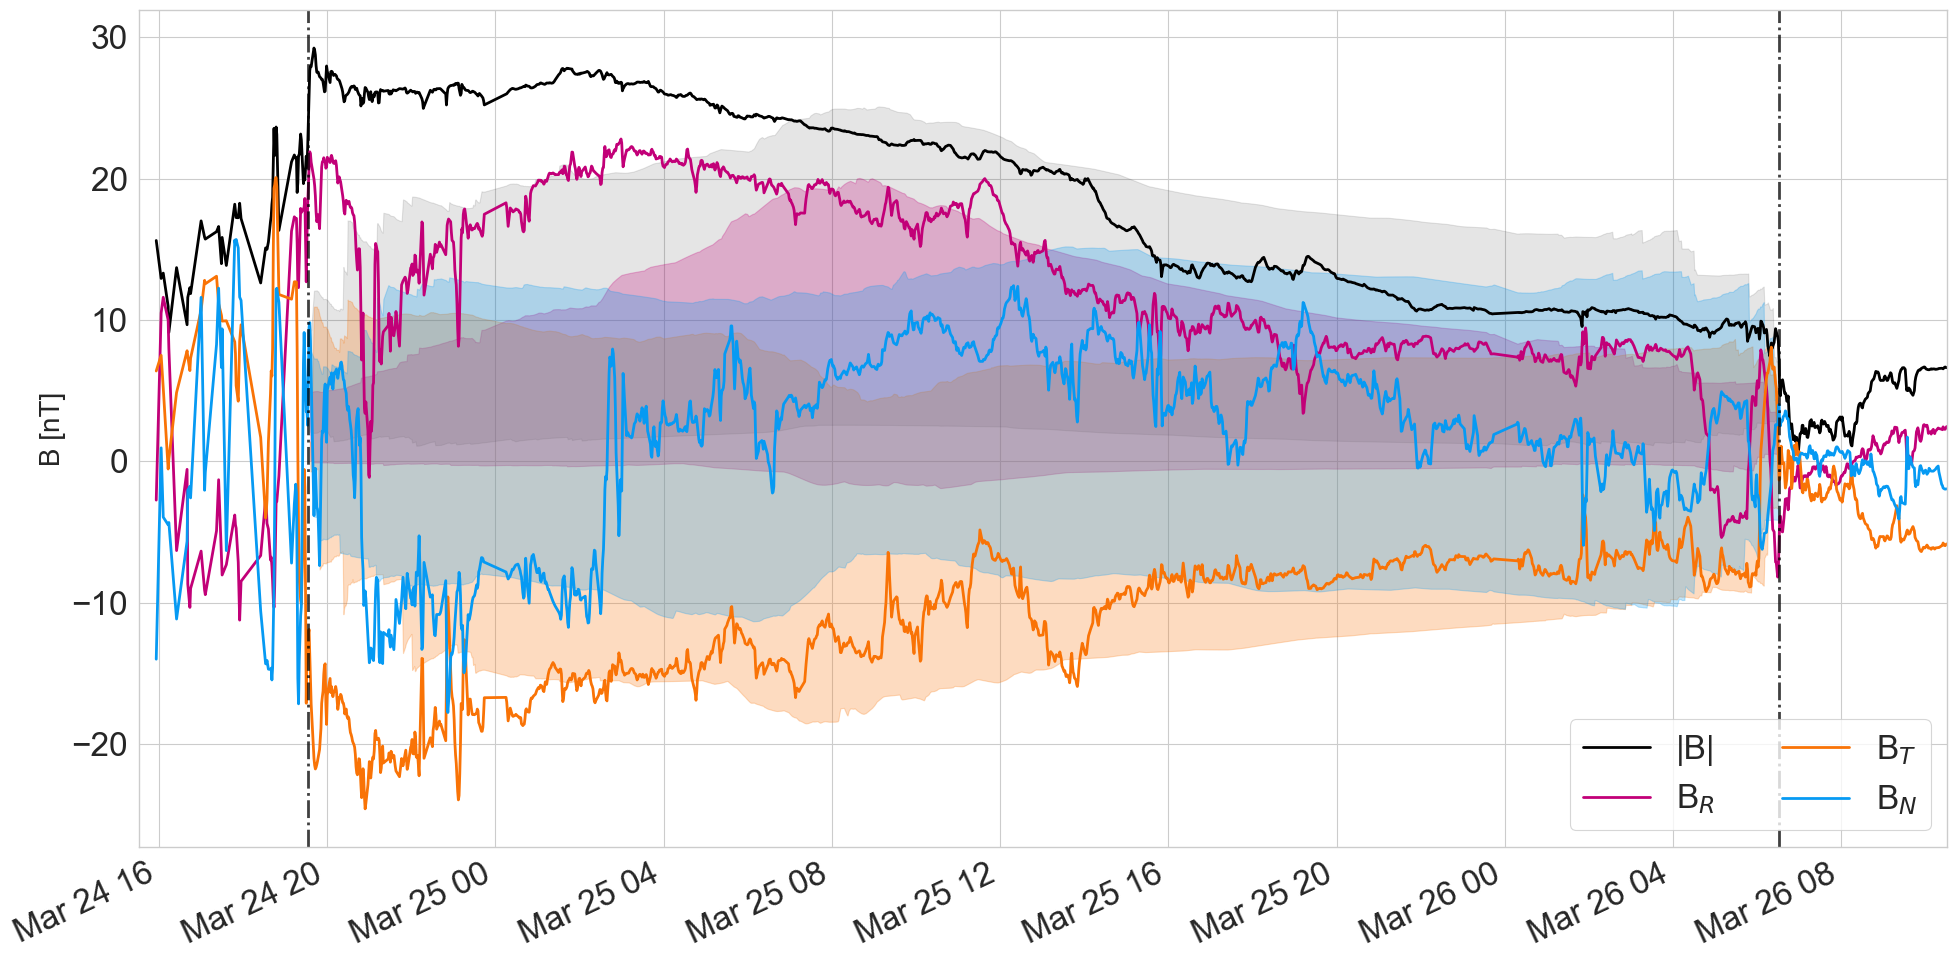

In [29]:
if t_s is not None and t_e is not None:
    insitu_start = t_s - datetime.timedelta(hours=4) # these can be set instead of delta_time_hours
    insitu_end = t_e + datetime.timedelta(hours=4) # these can be set instead of delta_time_hours
else:
    insitu_start = None
    insitu_end = None

fig, ax = plot_insitu_results(
    data_cache=data_cache_sta,
    reference_frame="RTN",
    delta_time_hours=2,
    insitu_start=insitu_start,
    insitu_end=insitu_end,
    t_s = t_s, # set to None if not to be plotted
    t_e = t_e, # set to None if not to be plotted
    t_fit = t_fit, # set to None if not to be plotted
    colors = insitu_colors,
    figsize=(20,10),
    fontsize=BIGGER_SIZE,
    lw_insitu=2,
    lw_best=3,
    lw_mean=3,
    lw_fitpts=2,
    ensemble_data=ensemble_data_sta,
)

if save_quick_results_plot:
    output_folder.mkdir(parents=True, exist_ok=True)
    fig.savefig(output_folder / f"{data_cache_sta.idd}_insitu_fitresults.png", dpi=200)

In [30]:
# Set new elements for data_cache so they can be used later on

data_cache_sta.row = row_sta

#### BepiColombo

In [31]:
idd_bepi = 'ICME_BEPI_MOESTL_20240324_01' # this is the ID of the event we want to analyze

# reduce delta_t_days to reduce computation time during ensemble generation
data_cache_bepi = get_data_cache(idd_bepi, mean_hours=24, delta_t_days = 3) # mean_hours is the number of hours before the event to calculate the mean solar wind speed

output_path = Path.cwd().parent / "output"
output_folder = output_path / data_cache_bepi.idd

Loading data from cache for ICME_BEPI_MOESTL_20240324_01


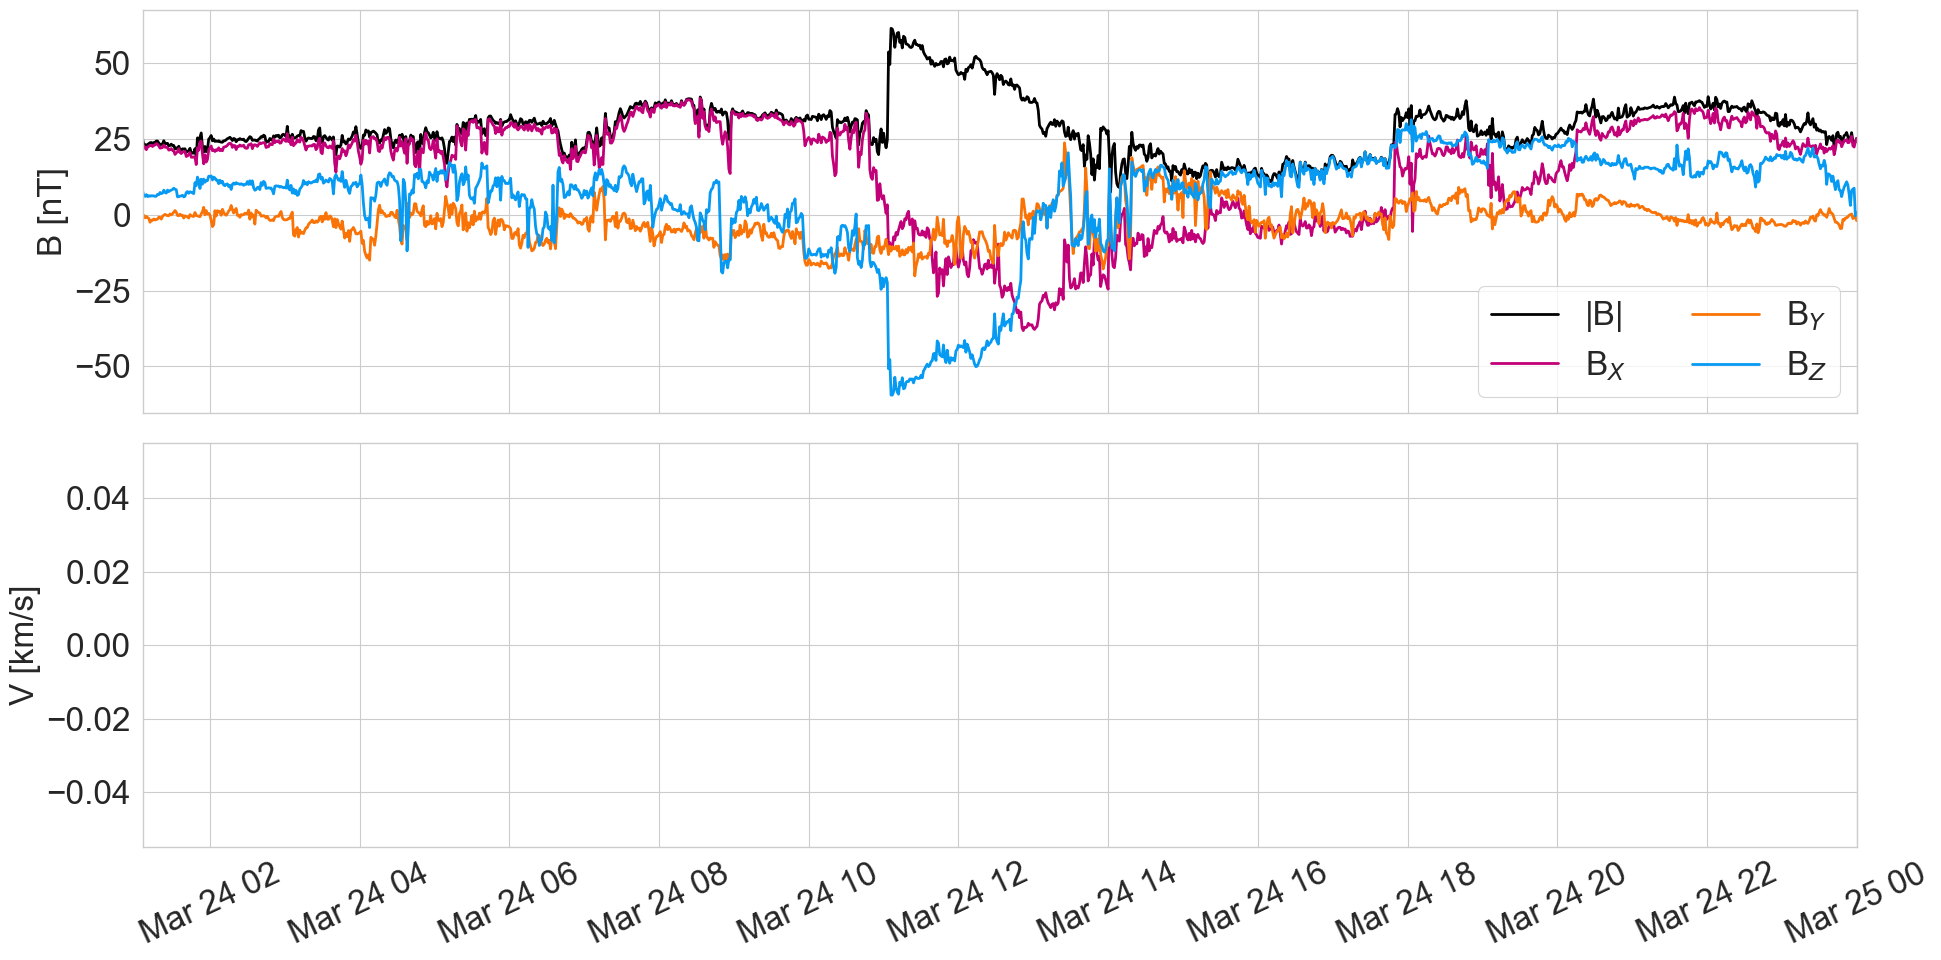

In [32]:
fig, axes = data_cache_bepi.quick_insitu_plot(
    reference_frame="HEEQ", 
    delta_time_hours=10, 
    colors=insitu_colors, 
    figsize=(20,10),
    fontsize=BIGGER_SIZE,
    lw_insitu=2
)

if save_quick_insitu_plot:
    output_folder.mkdir(parents=True, exist_ok=True)
    fig.savefig(output_folder / f"{data_cache_bepi.idd}_insitu_quicklook.png", dpi=200)

fig.show()

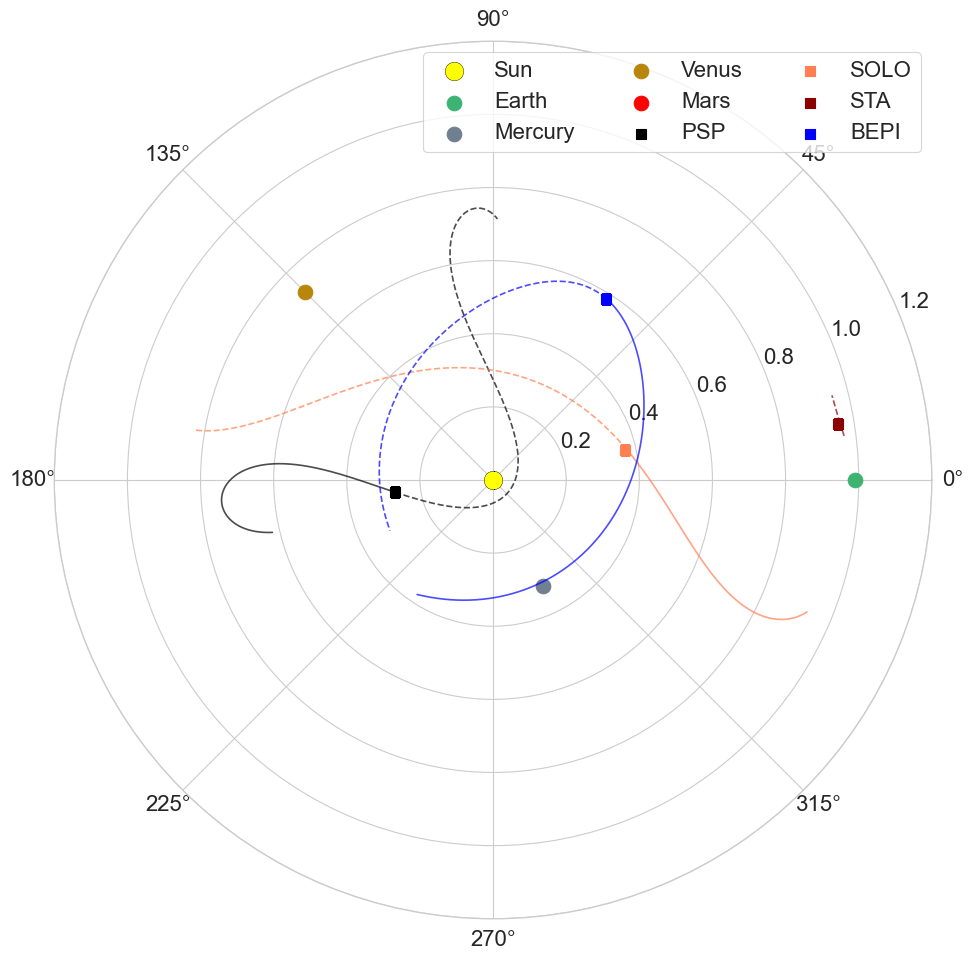

In [33]:
fig, ax = data_cache_bepi.quick_positions_plot(
    fontsize=SMALLEST_SIZE,
    figsize=(20,10)
)

if save_quick_positions_plot:
    output_folder.mkdir(parents=True, exist_ok=True)
    fig.savefig(output_folder / f"{data_cache_bepi.idd}_positions_quicklook.png", dpi=200)

fig.show()

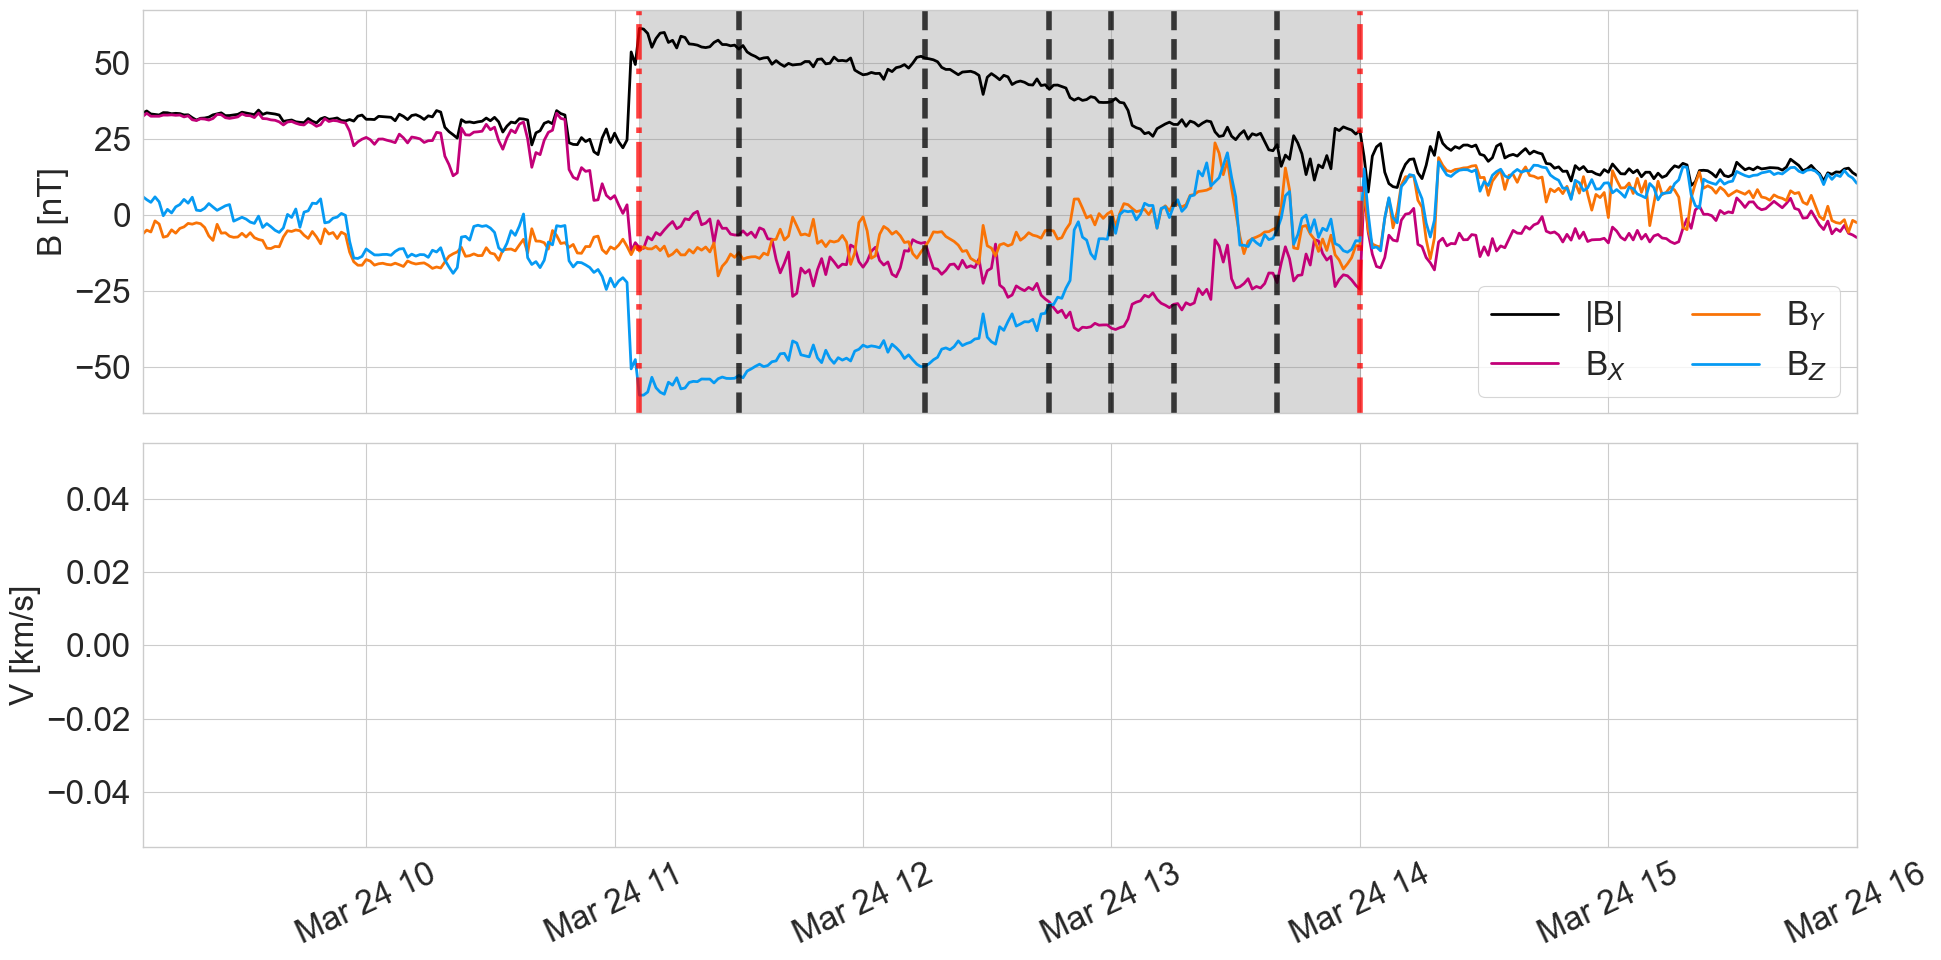

In [34]:
t_launch = cataloglaunchtime.replace(tzinfo=None) # choose launch time

t_s = data_cache_bepi.mo_begin # will be set to that automatically if None
t_e = data_cache_bepi.endtime # will be set to that automatically if None


t_fit = [
     datetime.datetime(2024, 3, 24, 11, 30),
     datetime.datetime(2024, 3, 24, 12, 15),
     datetime.datetime(2024, 3, 24, 12, 45),
     datetime.datetime(2024, 3, 24, 13, 0),
     datetime.datetime(2024, 3, 24, 13, 15),
     datetime.datetime(2024, 3, 24, 13, 40)
     ]


fig, axes = data_cache_bepi.check_fitting_points(
    t_s, 
    t_e, 
    t_fit, 
    colors=insitu_colors, 
    figsize=(20,10),
    fontsize=BIGGER_SIZE,
    lw_insitu=2,
    lw_fitpts=4
)

if save_quick_fitting_points_plot:
    output_folder.mkdir(parents=True, exist_ok=True)
    fig.savefig(output_folder / f"{data_cache_bepi.idd}_insitu_fittingpoints.png", dpi=200)

In [35]:
longitude_delta = 40
latitude_delta = 30

speed_delta = 100

bg_v_delta = 400

if data_cache_bepi.v_mean_before_event == None or pd.isna(data_cache_bepi.v_mean_before_event):
    bg_v = 500  # default value if no data
else:
    bg_v = data_cache_bepi.v_mean_before_event


modelstatevar_ranges = [
    int(2**18) # ensemblesize
    ] + [
        [catalogevent['longitude'] - longitude_delta,catalogevent['longitude']+longitude_delta], # Longitude (HEEQ)
        [catalogevent['latitude'] - latitude_delta,catalogevent['latitude'] +latitude_delta], # Latitude (HEEQ)
        [0.,360.], # Inclination
        [0.05,0.35], # Diameter 1 AU 
        [1.,3.5], # Aspect Ratio  
        [21.5,21.5], # Launch Radius
        [catalogevent['speed'] - speed_delta, catalogevent['speed'] + speed_delta], # Launch Velocity
        [1.,2.0], # Expansion Rate
        [0.20,3.00], # Background Drag
        [bg_v - bg_v_delta, bg_v + bg_v_delta], # Background Velocity
        [-250.,250.], # T_Factor
        [1.,2.], # Magnetic Decay Rate
        [5.,65.], # Magnetic Field Strength 1 AU
    ]

modelkwargs = get_modelkwargs_ranges(modelstatevar_ranges)

multiprocessing = True

njobs = 4

itermin = 12
itermax = 15

n_particles = 512

In [36]:
rerun_fitting = False

fit_number = "last" # "last" or integer

if rerun_fitting:
    extra_args = standard_fit(
        data_cache = data_cache_bepi,
        t_launch=t_launch,
        t_s=t_s,
        t_e=t_e,
        t_fit=t_fit,
        model_kwargs=modelkwargs,
        njobs=njobs,
        multiprocessing=multiprocessing,
        itermin=itermin,
        itermax=itermax,
        n_particles=n_particles,
    )

if fit_number == "last":
    fit_files = [
        f for f in output_folder.glob("*.pickle")
        if re.match(r"^\d{2}\.pickle$", f.name)
    ]
    fit_files.sort()

    if fit_files == []:
        print(f"No fitting results found, set rerun_fitting to True")
    else:
        fit_file = fit_files[-1]
else:
    fit_file = output_folder / f"{fit_number:02d}.pickle"

try:
    with open(fit_file, "rb") as fh:
        extra_args = pickle.load(fh)

    print("Loaded fit from file: ", fit_file)
except:
    print(f"Error loading fit results")

Loaded fit from file:  /Users/hannahruedisser/3DCORE-ASWO/output/ICME_BEPI_MOESTL_20240324_01/09.pickle


In [37]:
ensemble_data_bepi = load_ensemble(output_folder= output_folder, fit_file=fit_file, data_cache=data_cache_bepi)

Loaded ensemble from /Users/hannahruedisser/3DCORE-ASWO/output/ICME_BEPI_MOESTL_20240324_01/ensemble_09.pickle


In [38]:
results_df_bepi, stats_df_bepi = load_fit_parameters(fit_file=fit_file, t0=t_launch)

In [39]:
results_df_bepi.head()

Index  RMSE Ɛ  Longitude  Latitude  Inclination  Diameter 1 AU  \
0     0    0.38      29.00     28.20       133.05           0.06   
1     1    0.40      34.76     19.94       133.03           0.07   
2     2    0.39      27.98     33.25       130.24           0.07   
3     3    0.37      26.27     31.46       133.28           0.07   
4     4    0.36      22.90     25.50       141.05           0.07   

   Aspect Ratio  Launch Radius  Launch Velocity  T_Factor  Expansion Rate  \
0          3.32           21.5          1620.18    176.27            1.32   
1          2.89           21.5          1518.99    182.16            1.34   
2          3.23           21.5          1620.43    232.03            1.60   
3          3.37           21.5          1683.51    220.32            1.41   
4          3.30           21.5          1705.67    204.54            1.77   

   Magnetic Decay Rate  Magnetic Field Strength 1 AU  Background Drag  \
0                 1.45                         16.35             0.88   
1                 1.75                         17.55             2.10   
2                 1.24                         15.51             1.96   
3                 1.80                         18.16             1.82   
4                 1.60                         14.90             2.12   

   Background Velocity  Number of Twists       Launch Time  
0               691.26             12.10  2024-03-23 03:19  
1               661.26             14.05  2024-03-23 03:19  
2               872.26             16.29  2024-03-23 03:19  
3               857.95             14.94  2024-03-23 03:19  
4               837.40             14.11  2024-03-23 03:19

In [40]:
stats_df_bepi.head()

Index  RMSE Ɛ  Longitude  Latitude  Inclination  \
0                Mean    0.38      32.16     24.61       132.09   
1  Standard Deviation    0.02       5.47      4.81         5.99   
2              Median     NaN        NaN       NaN          NaN   
3             Minimum    0.29      17.47      9.71       115.69   
4             Maximum    0.40      41.95     36.01       152.42   

   Diameter 1 AU  Aspect Ratio  Launch Radius  Launch Velocity  T_Factor  \
0           0.07          2.71           21.5          1613.72    170.52   
1           0.01          0.54            0.0            55.40     42.44   
2            NaN           NaN            NaN              NaN       NaN   
3           0.05          1.13           21.5          1514.36     70.29   
4           0.11          3.49           21.5          1712.28    249.94   

   Expansion Rate  Magnetic Decay Rate  Magnetic Field Strength 1 AU  \
0            1.49                 1.50                         17.55   
1            0.27                 0.27                          2.55   
2             NaN                  NaN                           NaN   
3            1.00                 1.00                         11.12   
4            2.00                 1.99                         26.16   

   Background Drag  Background Velocity  Number of Twists       Launch Time  
0             1.89               710.95             14.34  2024-03-23 03:19  
1             0.69                94.97              4.70  2024-03-23 03:19  
2              NaN                  NaN               NaN  2024-03-23 03:19  
3             0.27               324.34              4.98  2024-03-23 03:19  
4             3.00               899.13             35.70  2024-03-23 03:19

In [41]:
max_col_width = max(len(str(col)) for col in stats_df_bepi.columns[2:-1])

for col in stats_df_bepi.columns[1:-1]:
    print('{:<{}}{:>20} +/- {:>20}'.format(str(col) + ':', max_col_width + 1, str(stats_df_bepi[col][0]), str(stats_df_bepi[col][1])))

RMSE Ɛ:                                      0.38 +/-                 0.02
Longitude:                                  32.16 +/-                 5.47
Latitude:                                   24.61 +/-                 4.81
Inclination:                               132.09 +/-                 5.99
Diameter 1 AU:                               0.07 +/-                 0.01
Aspect Ratio:                                2.71 +/-                 0.54
Launch Radius:                               21.5 +/-                  0.0
Launch Velocity:                          1613.72 +/-                 55.4
T_Factor:                                  170.52 +/-                42.44
Expansion Rate:                              1.49 +/-                 0.27
Magnetic Decay Rate:                          1.5 +/-                 0.27
Magnetic Field Strength 1 AU:               17.55 +/-                 2.55
Background Drag:                             1.89 +/-                 0.69
Background Velocity:     

In [42]:
row_bepi = results_df_bepi.iloc[results_df_bepi['RMSE Ɛ'].idxmin()] # extract parameters from minimum eps row

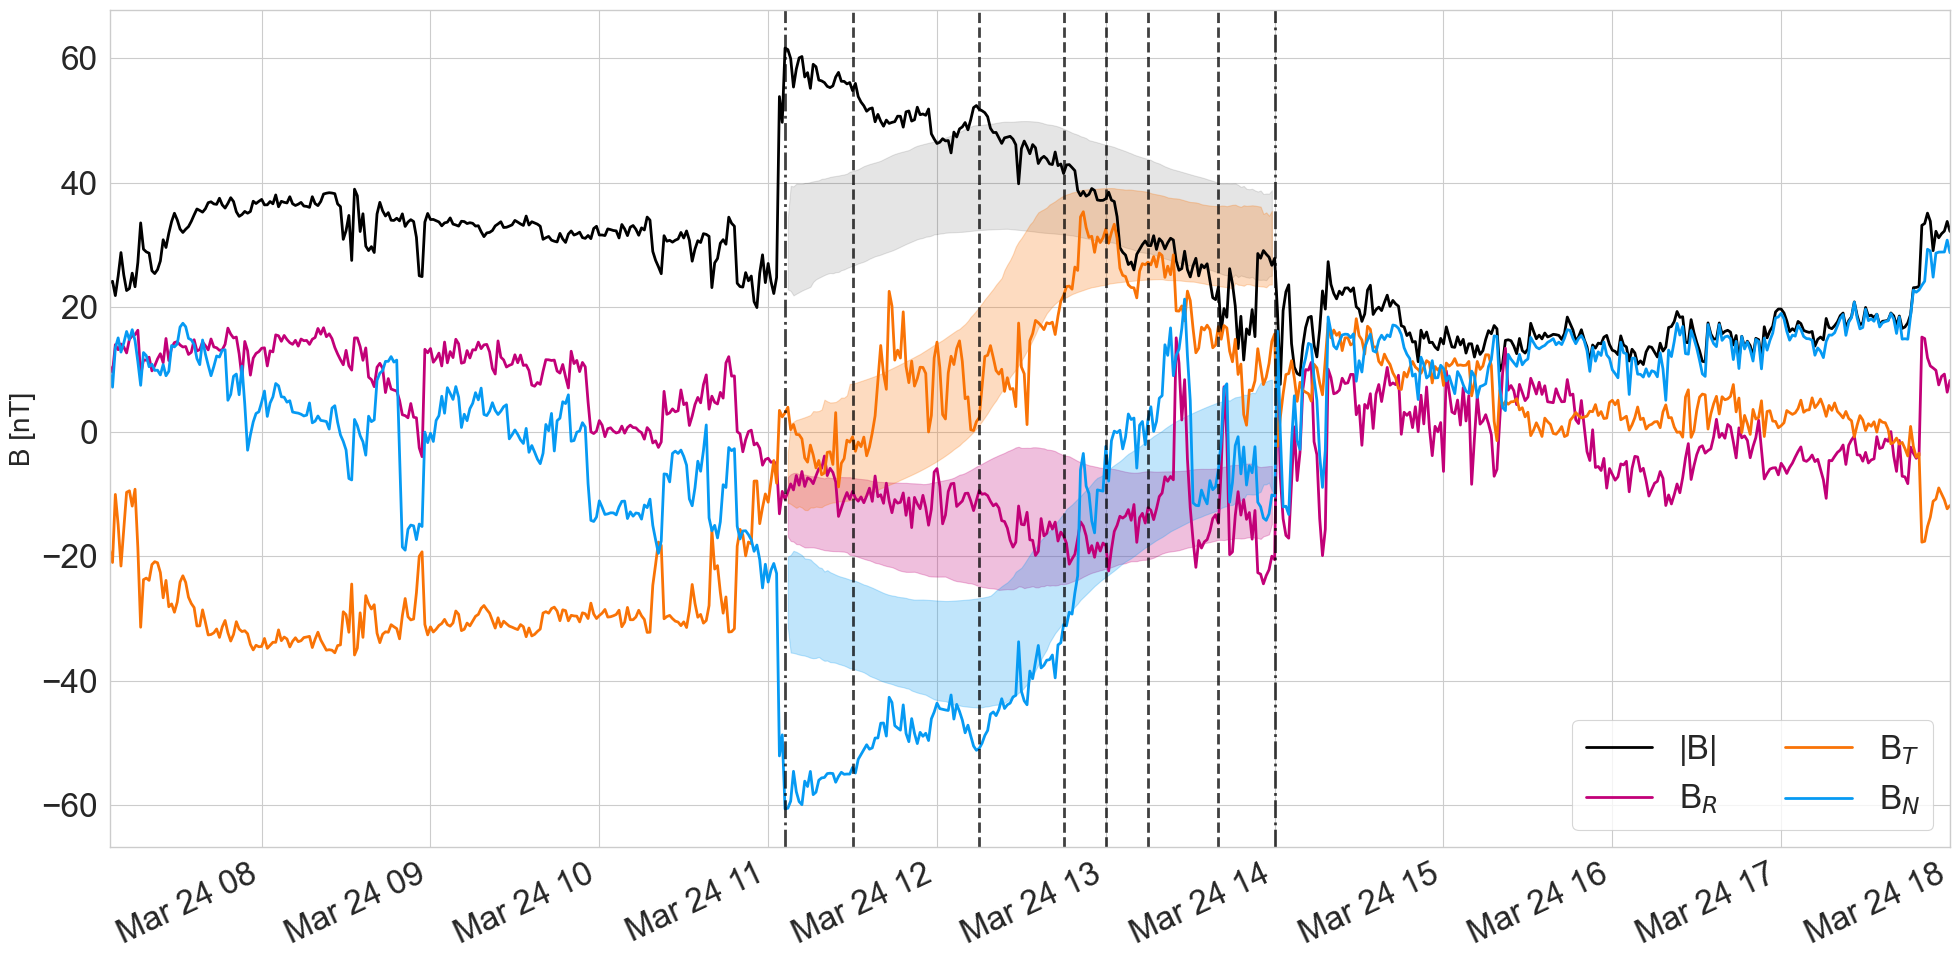

In [43]:
if t_s is not None and t_e is not None:
    insitu_start = t_s - datetime.timedelta(hours=4) # these can be set instead of delta_time_hours
    insitu_end = t_e + datetime.timedelta(hours=4) # these can be set instead of delta_time_hours
else:
    insitu_start = None
    insitu_end = None

fig, ax = plot_insitu_results(
    data_cache=data_cache_bepi,
    reference_frame="RTN",
    delta_time_hours=2,
    insitu_start=insitu_start,
    insitu_end=insitu_end,
    t_s = t_s, # set to None if not to be plotted
    t_e = t_e, # set to None if not to be plotted
    t_fit = t_fit, # set to None if not to be plotted
    colors = insitu_colors,
    figsize=(20,10),
    fontsize=BIGGER_SIZE,
    lw_insitu=2,
    lw_best=3,
    lw_mean=3,
    lw_fitpts=2,
    ensemble_data=ensemble_data_bepi,
)

if save_quick_results_plot:
    output_folder.mkdir(parents=True, exist_ok=True)
    fig.savefig(output_folder / f"{data_cache_bepi.idd}_insitu_fitresults.png", dpi=200)

In [44]:
# Set new elements for data_cache so they can be used later on

data_cache_bepi.row = row_bepi

#### Wind

In [45]:
idd_wind = 'ICME_Wind_MOESTL_20240324_01' # this is the ID of the event we want to analyze

# reduce delta_t_days to reduce computation time during ensemble generation
data_cache_wind = get_data_cache(idd_wind, mean_hours=24, delta_t_days = 3) # mean_hours is the number of hours before the event to calculate the mean solar wind speed

output_path = Path.cwd().parent / "output"
output_folder = output_path / data_cache_wind.idd

Loading data from cache for ICME_Wind_MOESTL_20240324_01


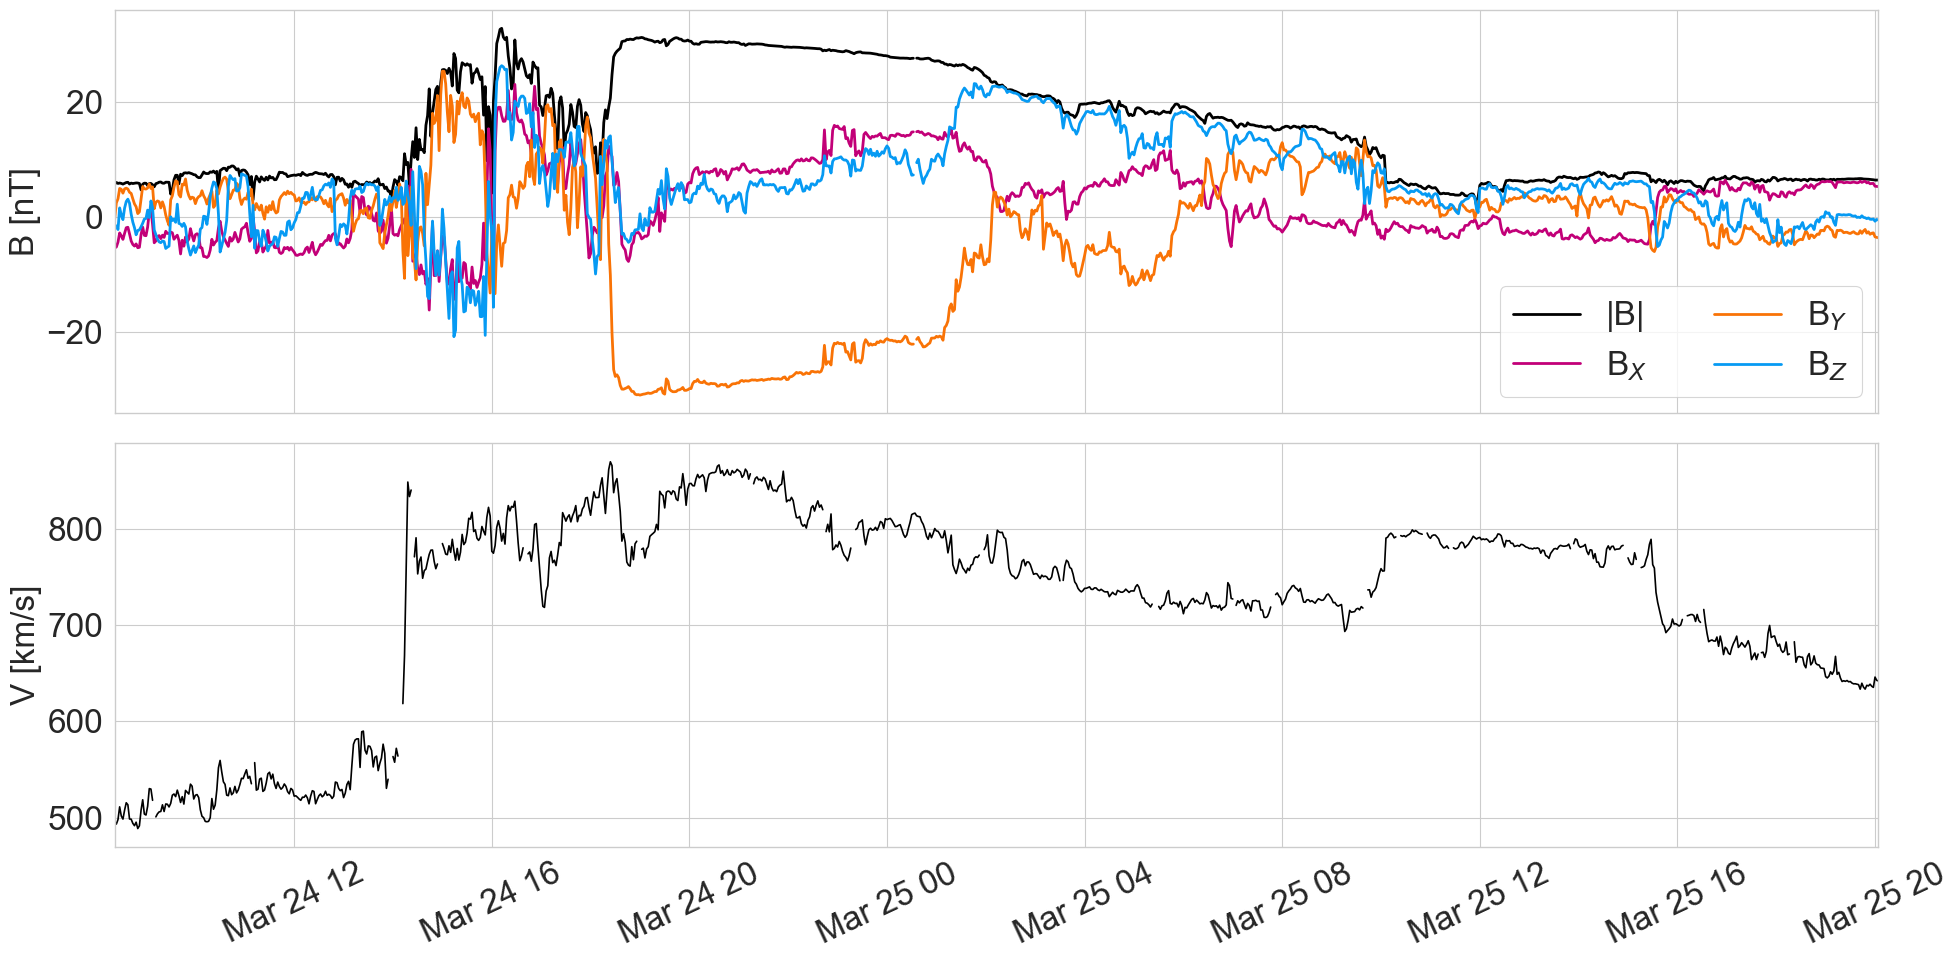

In [46]:
fig, axes = data_cache_wind.quick_insitu_plot(
    reference_frame="HEEQ", 
    delta_time_hours=10, 
    colors=insitu_colors, 
    figsize=(20,10),
    fontsize=BIGGER_SIZE,
    lw_insitu=2
)

if save_quick_insitu_plot:
    output_folder.mkdir(parents=True, exist_ok=True)
    fig.savefig(output_folder / f"{data_cache_wind.idd}_insitu_quicklook.png", dpi=200)

fig.show()

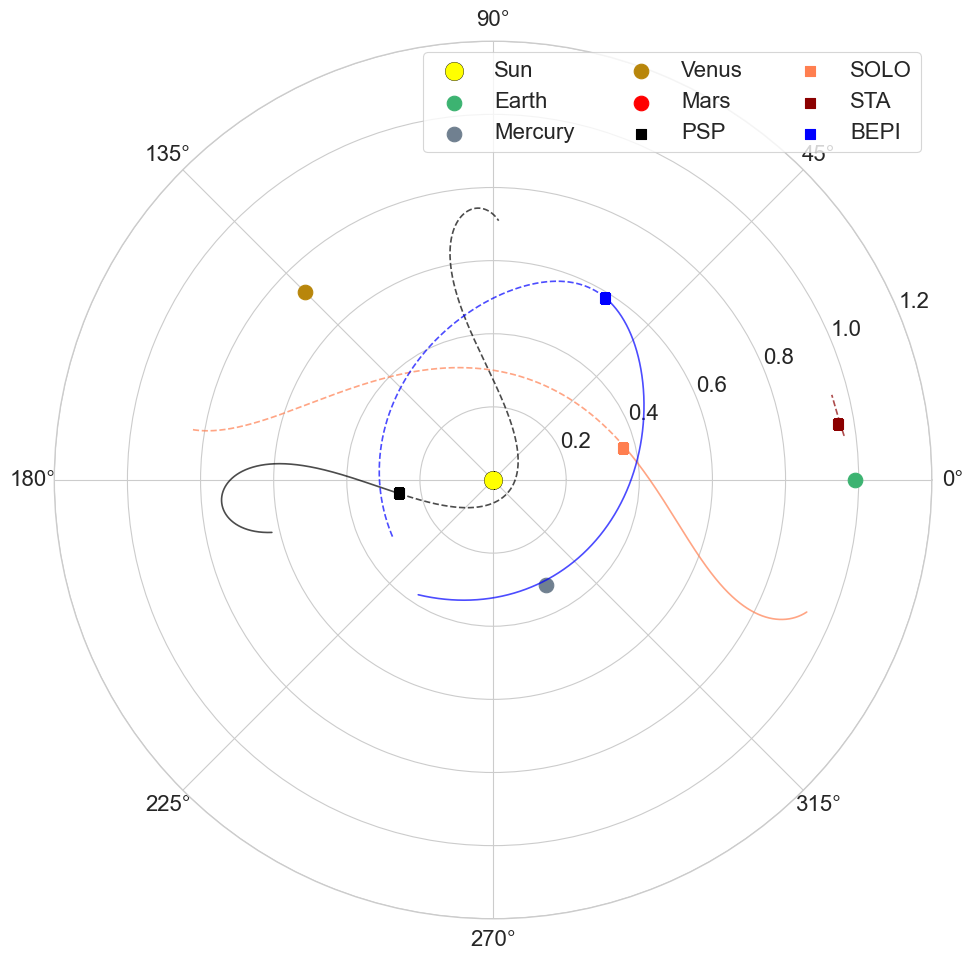

In [47]:
fig, ax = data_cache_wind.quick_positions_plot(
    fontsize=SMALLEST_SIZE,
    figsize=(20,10)
)

if save_quick_positions_plot:
    output_folder.mkdir(parents=True, exist_ok=True)
    fig.savefig(output_folder / f"{data_cache_wind.idd}_positions_quicklook.png", dpi=200)

fig.show()

Fitting points not given, setting to 4 equidistant points between 2024-03-24 18:22:00 and 2024-03-25 10:04:00:


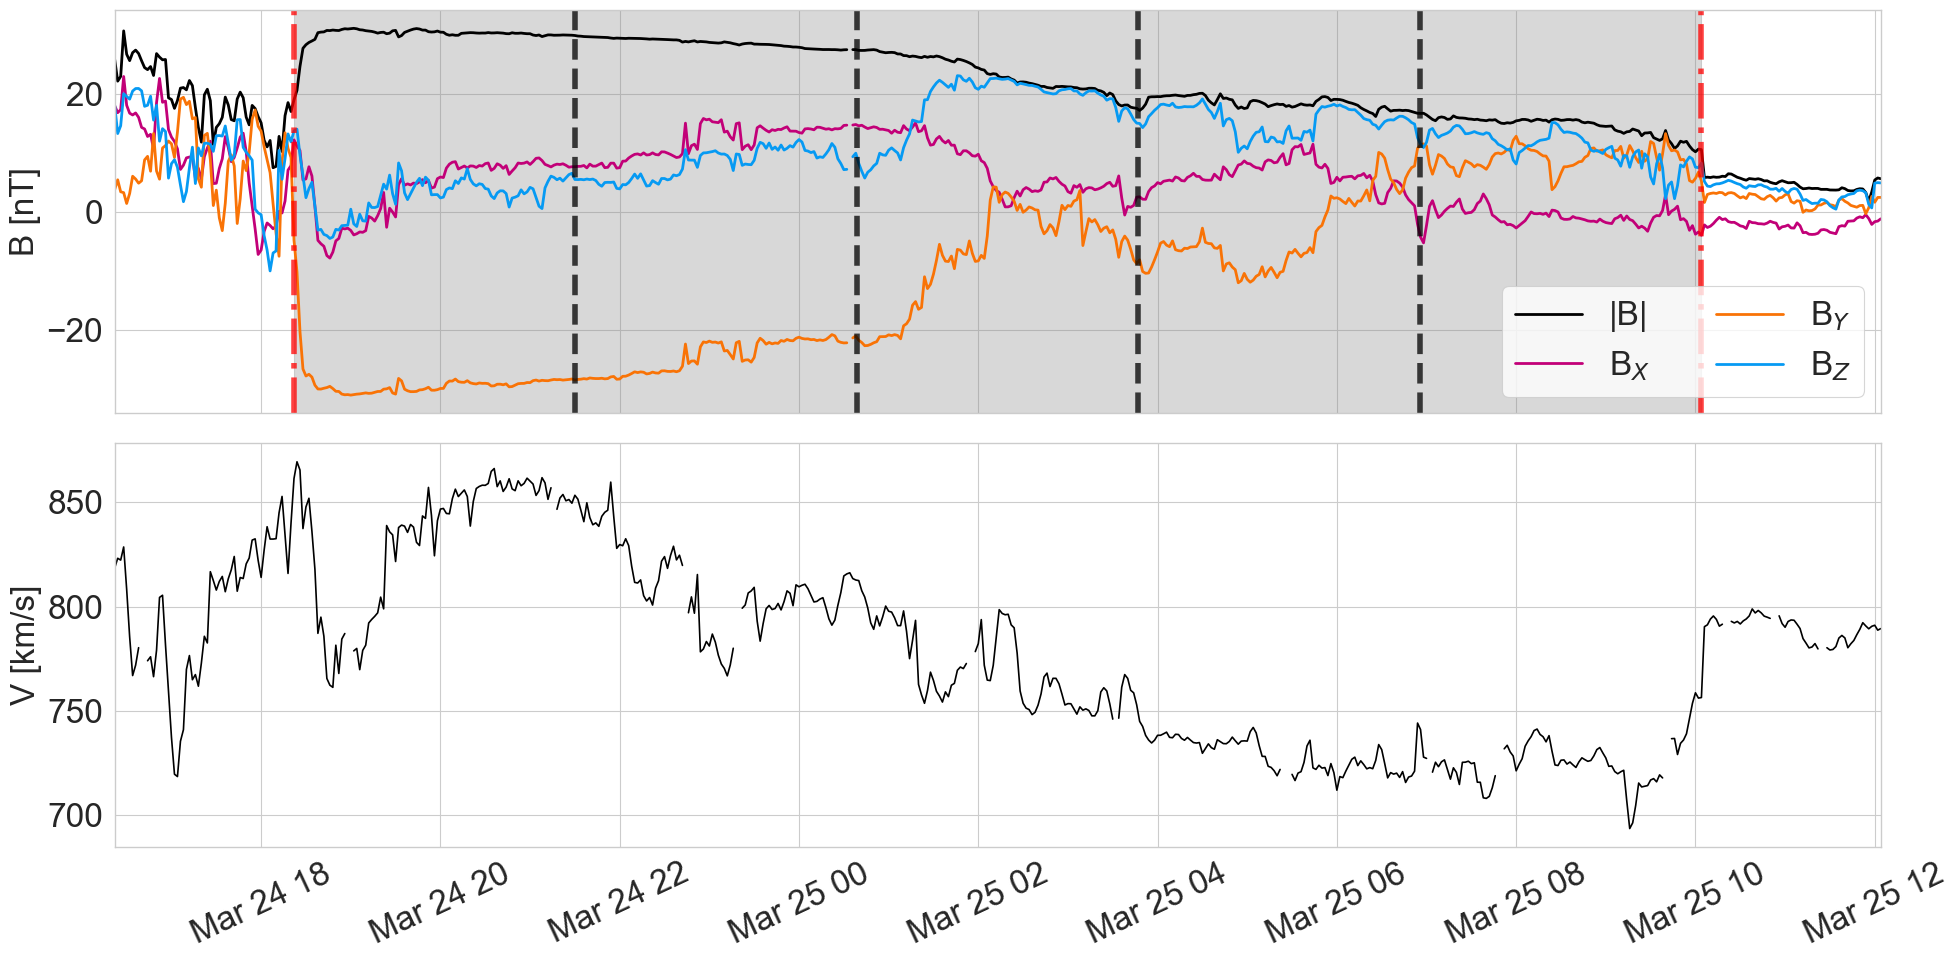

In [48]:
t_launch = cataloglaunchtime.replace(tzinfo=None) # choose launch time

t_s = data_cache_wind.mo_begin # will be set to that automatically if None
t_e = data_cache_wind.endtime # will be set to that automatically if None


t_fit = None


fig, axes = data_cache_wind.check_fitting_points(
    t_s, 
    t_e, 
    t_fit, 
    colors=insitu_colors, 
    figsize=(20,10),
    fontsize=BIGGER_SIZE,
    lw_insitu=2,
    lw_fitpts=4
)

if save_quick_fitting_points_plot:
    output_folder.mkdir(parents=True, exist_ok=True)
    fig.savefig(output_folder / f"{data_cache_wind.idd}_insitu_fittingpoints.png", dpi=200)

In [49]:
longitude_delta = 40
latitude_delta = 30

speed_delta = 100

bg_v_delta = 100
bg_v = data_cache_wind.v_mean_before_event


modelstatevar_ranges = [
    int(2**18) # ensemblesize
    ] + [
        [catalogevent['longitude'] - longitude_delta,catalogevent['longitude']+longitude_delta], # Longitude (HEEQ)
        [catalogevent['latitude'] - latitude_delta,catalogevent['latitude'] +latitude_delta], # Latitude (HEEQ)
        [0.,360.], # Inclination
        [0.05,0.35], # Diameter 1 AU 
        [1.,3.5], # Aspect Ratio  
        [21.5,21.5], # Launch Radius
        [catalogevent['speed'] - speed_delta, catalogevent['speed'] + speed_delta], # Launch Velocity
        [1.,2.0], # Expansion Rate
        [0.20,3.00], # Background Drag
        [bg_v - bg_v_delta, bg_v + bg_v_delta], # Background Velocity
        [-250.,250.], # T_Factor
        [1.,2.], # Magnetic Decay Rate
        [5.,65.], # Magnetic Field Strength 1 AU
    ]

modelkwargs = get_modelkwargs_ranges(modelstatevar_ranges)

multiprocessing = True

njobs = 4

itermin = 12
itermax = 15

n_particles = 512

In [50]:
rerun_fitting = False

fit_number = "last" # "last" or integer

if rerun_fitting:
    extra_args = standard_fit(
        data_cache = data_cache_wind,
        t_launch=t_launch,
        t_s=t_s,
        t_e=t_e,
        t_fit=t_fit,
        model_kwargs=modelkwargs,
        njobs=njobs,
        multiprocessing=multiprocessing,
        itermin=itermin,
        itermax=itermax,
        n_particles=n_particles,
    )

if fit_number == "last":
    fit_files = [
        f for f in output_folder.glob("*.pickle")
        if re.match(r"^\d{2}\.pickle$", f.name)
    ]
    fit_files.sort()

    if fit_files == []:
        print(f"No fitting results found, set rerun_fitting to True")
    else:
        fit_file = fit_files[-1]
else:
    fit_file = output_folder / f"{fit_number:02d}.pickle"

try:
    with open(fit_file, "rb") as fh:
        extra_args = pickle.load(fh)

    print("Loaded fit from file: ", fit_file)
except:
    print(f"Error loading fit results")

Loaded fit from file:  /Users/hannahruedisser/3DCORE-ASWO/output/ICME_Wind_MOESTL_20240324_01/04.pickle


In [53]:
ensemble_data_wind = load_ensemble(output_folder= output_folder, fit_file=fit_file, data_cache=data_cache_wind)

Loaded ensemble from /Users/hannahruedisser/3DCORE-ASWO/output/ICME_Wind_MOESTL_20240324_01/ensemble_04.pickle


In [54]:
results_df_wind, stats_df_wind = load_fit_parameters(fit_file=fit_file, t0=t_launch)

In [55]:
results_df_wind.head()

Index  RMSE Ɛ  Longitude  Latitude  Inclination  Diameter 1 AU  \
0     0    0.63      -7.35     -2.35       316.66           0.15   
1     1    0.64      -8.91      6.39       299.78           0.17   
2     2    0.63     -14.78     -5.29       333.10           0.15   
3     3    0.65      -8.63      1.12       300.82           0.17   
4     4    0.67     -14.12     12.55       315.35           0.14   

   Aspect Ratio  Launch Radius  Launch Velocity  T_Factor  Expansion Rate  \
0          1.98           21.5          1576.02    -75.77            1.57   
1          2.22           21.5          1530.68    -72.96            1.26   
2          2.18           21.5          1554.44    -74.70            1.68   
3          2.80           21.5          1707.54    -31.67            1.67   
4          2.66           21.5          1554.15    -12.96            1.88   

   Magnetic Decay Rate  Magnetic Field Strength 1 AU  Background Drag  \
0                 1.27                         24.73             0.34   
1                 1.01                         21.65             0.23   
2                 1.51                         38.24             0.26   
3                 1.56                         22.66             0.27   
4                 1.72                         20.29             0.24   

   Background Velocity  Number of Twists       Launch Time  
0               555.50             -7.88  2024-03-23 03:19  
1               531.08             -6.96  2024-03-23 03:19  
2               530.79             -7.22  2024-03-23 03:19  
3               503.81             -2.51  2024-03-23 03:19  
4               560.98             -1.07  2024-03-23 03:19

In [56]:
stats_df_wind.head()

Index  RMSE Ɛ  Longitude  Latitude  Inclination  \
0                Mean    0.63      -7.93      2.32       309.03   
1  Standard Deviation    0.04       4.51      5.98        12.43   
2              Median     NaN        NaN       NaN          NaN   
3             Minimum    0.40     -21.42     -7.95       270.27   
4             Maximum    0.68       5.02     19.63       350.46   

   Diameter 1 AU  Aspect Ratio  Launch Radius  Launch Velocity  T_Factor  \
0           0.16          2.53           21.5          1614.94    -65.03   
1           0.02          0.62            0.0            54.21     32.53   
2            NaN           NaN            NaN              NaN       NaN   
3           0.12          1.01           21.5          1513.18   -206.98   
4           0.21          3.50           21.5          1712.55      0.49   

   Expansion Rate  Magnetic Decay Rate  Magnetic Field Strength 1 AU  \
0            1.47                 1.54                         26.46   
1            0.27                 0.28                          5.91   
2             NaN                  NaN                           NaN   
3            1.00                 1.00                         12.55   
4            1.99                 2.00                         48.23   

   Background Drag  Background Velocity  Number of Twists       Launch Time  
0             0.28               523.68             -5.81  2024-03-23 03:19  
1             0.05                38.74              3.10  2024-03-23 03:19  
2              NaN                  NaN               NaN  2024-03-23 03:19  
3             0.20               412.83            -19.36  2024-03-23 03:19  
4             0.47               586.58              0.05  2024-03-23 03:19

In [57]:
max_col_width = max(len(str(col)) for col in stats_df_wind.columns[2:-1])

for col in stats_df_wind.columns[1:-1]:
    print('{:<{}}{:>20} +/- {:>20}'.format(str(col) + ':', max_col_width + 1, str(stats_df_wind[col][0]), str(stats_df_wind[col][1])))

RMSE Ɛ:                                      0.63 +/-                 0.04
Longitude:                                  -7.93 +/-                 4.51
Latitude:                                    2.32 +/-                 5.98
Inclination:                               309.03 +/-                12.43
Diameter 1 AU:                               0.16 +/-                 0.02
Aspect Ratio:                                2.53 +/-                 0.62
Launch Radius:                               21.5 +/-                  0.0
Launch Velocity:                          1614.94 +/-                54.21
T_Factor:                                  -65.03 +/-                32.53
Expansion Rate:                              1.47 +/-                 0.27
Magnetic Decay Rate:                         1.54 +/-                 0.28
Magnetic Field Strength 1 AU:               26.46 +/-                 5.91
Background Drag:                             0.28 +/-                 0.05
Background Velocity:     

In [58]:
row_wind= results_df_wind.iloc[results_df_wind['RMSE Ɛ'].idxmin()] # extract parameters from minimum eps row


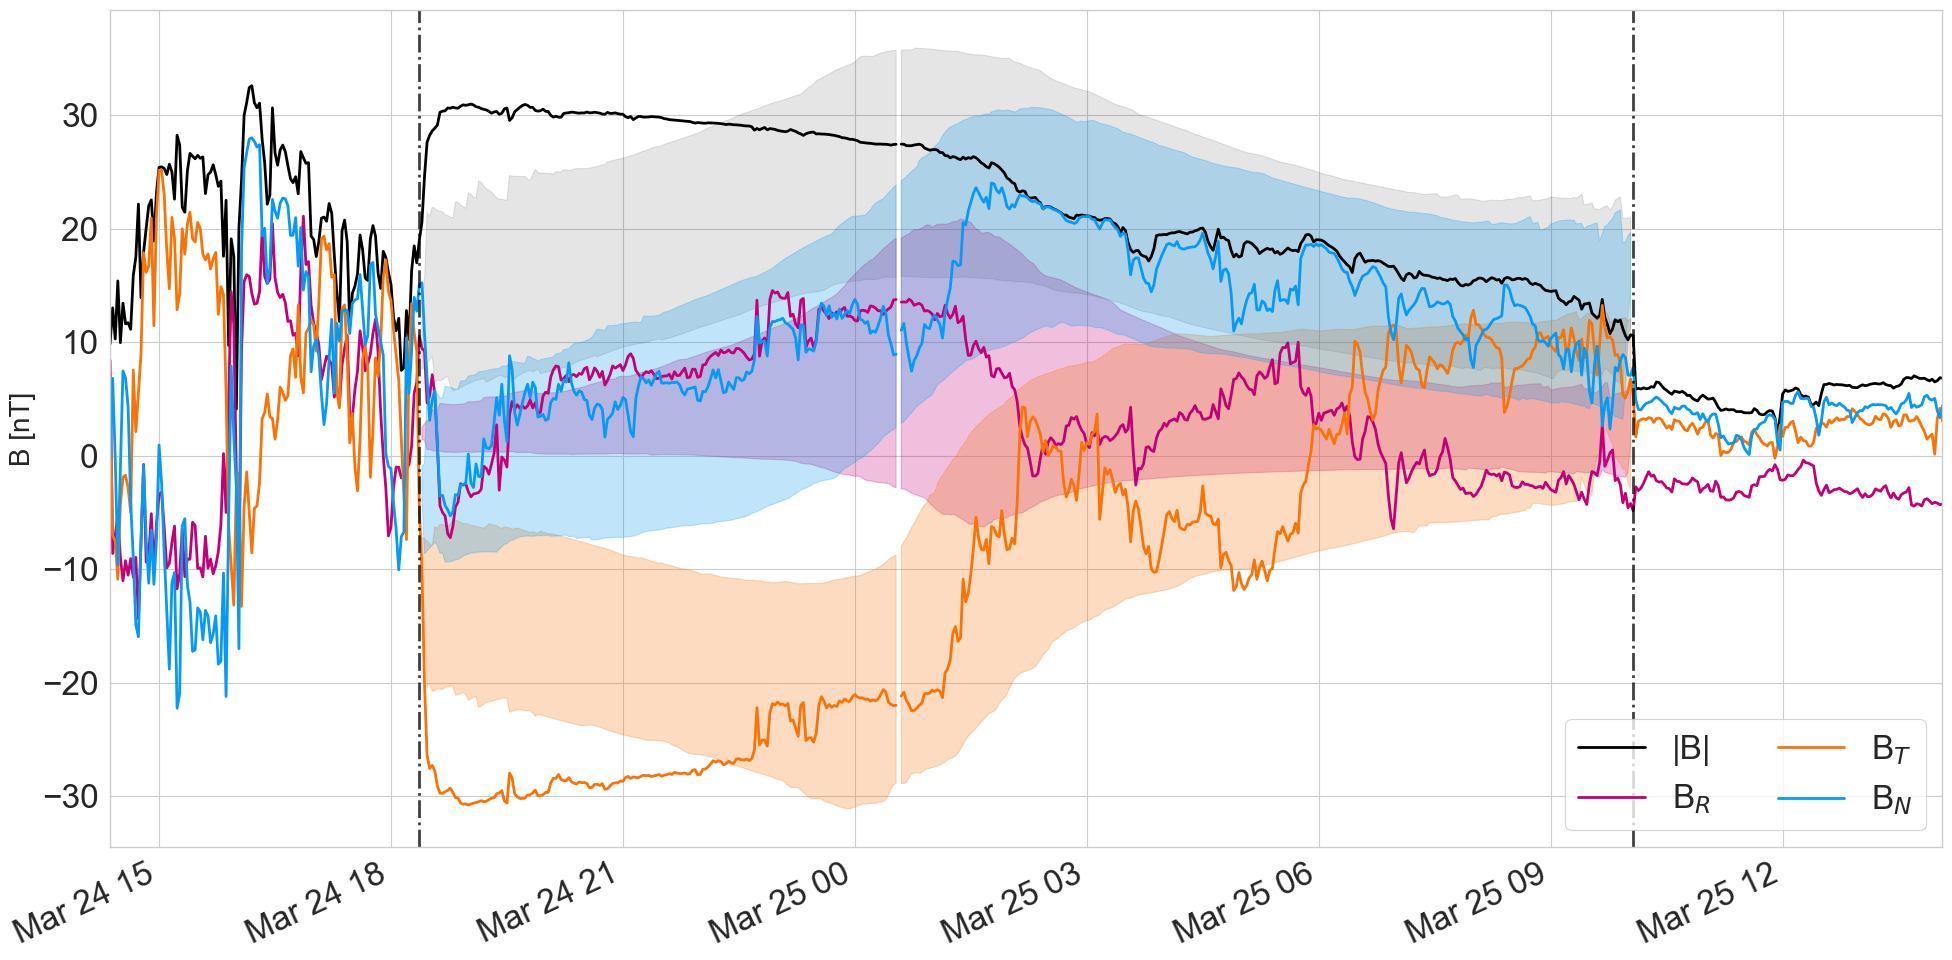

In [59]:
if t_s is not None and t_e is not None:
    insitu_start = t_s - datetime.timedelta(hours=4) # these can be set instead of delta_time_hours
    insitu_end = t_e + datetime.timedelta(hours=4) # these can be set instead of delta_time_hours
else:
    insitu_start = None
    insitu_end = None

fig, ax = plot_insitu_results(
    data_cache=data_cache_wind,
    reference_frame="RTN",
    delta_time_hours=2,
    insitu_start=insitu_start,
    insitu_end=insitu_end,
    t_s = t_s, # set to None if not to be plotted
    t_e = t_e, # set to None if not to be plotted
    t_fit = t_fit, # set to None if not to be plotted
    colors = insitu_colors,
    figsize=(20,10),
    fontsize=BIGGER_SIZE,
    lw_insitu=2,
    lw_best=3,
    lw_mean=3,
    lw_fitpts=2,
    ensemble_data=ensemble_data_wind,
)

if save_quick_results_plot:
    output_folder.mkdir(parents=True, exist_ok=True)
    fig.savefig(output_folder / f"{data_cache_wind.idd}_insitu_fitresults.png", dpi=200)

In [60]:
# Set new elements for data_cache so they can be used later on

data_cache_wind.row = row_wind

#### 3D Plotting

In [61]:
spacecraft = {
    #"psp": "black", 
    "solo":"coral", 
    "sta":"darkred", 
    #"stb":"darkgreen", 
    "bepi":"blue"
    } 

planets = {
    "earth":"mediumseagreen", 
    #"mercury":"slategrey", 
    #"venus":"darkgoldenrod", 
    #"mars":"red"
    }

hours_after_launch = 17

t_snap = t_launch + datetime.timedelta(hours=hours_after_launch)

print(f"Plotting snapshot at {t_snap} ({hours_after_launch} hours after launch)")

Plotting snapshot at 2024-03-23 20:19:00 (17 hours after launch)


Plotting solo CME
Tracing Fieldlines
array must not contain infs or NaNs
total turns estimates:  0.9993440261032509
Plotting sta CME
Tracing Fieldlines
Residuals are not finite in the initial point.
total turns estimates:  9.370850152566078
Plotting bepi CME
Tracing Fieldlines
Residuals are not finite in the initial point.
total turns estimates:  22.454262074615073
Plotting wind CME
Tracing Fieldlines
Residuals are not finite in the initial point.
total turns estimates:  6.9679410323214945


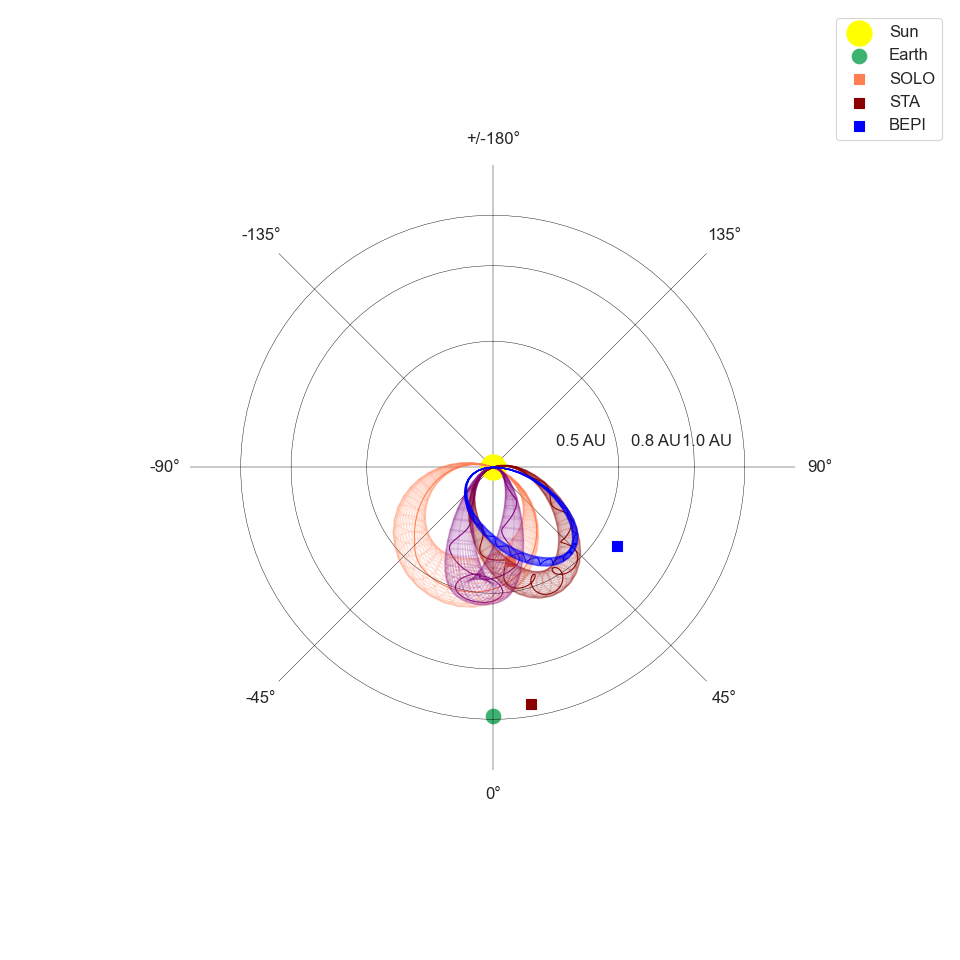

Saved 3D snapshot with azim 0, elev 90, radius 1.2
Plotting solo CME
Tracing Fieldlines
array must not contain infs or NaNs
total turns estimates:  0.9993440261032509
Plotting sta CME
Tracing Fieldlines
Residuals are not finite in the initial point.
total turns estimates:  9.370850152566078
Plotting bepi CME
Tracing Fieldlines
Residuals are not finite in the initial point.
total turns estimates:  22.454262074615073
Plotting wind CME
Tracing Fieldlines
Residuals are not finite in the initial point.
total turns estimates:  6.9679410323214945


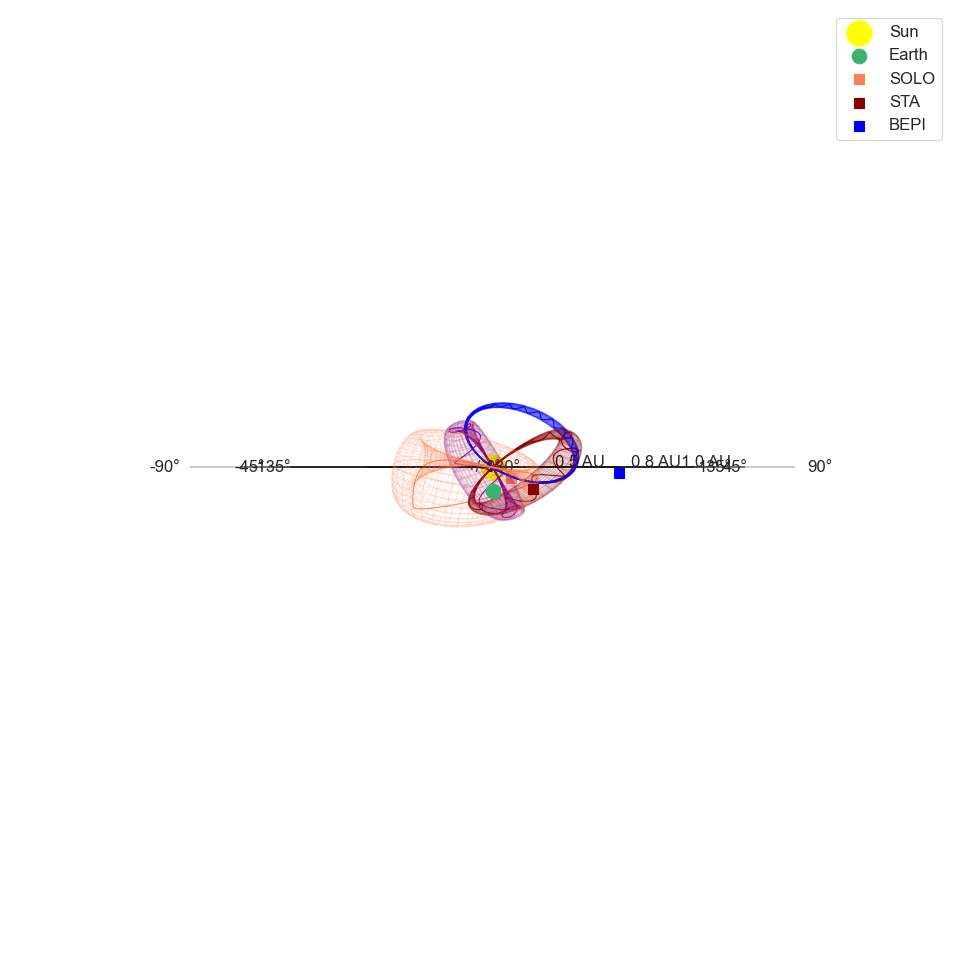

Saved 3D snapshot with azim 0, elev 0, radius 1.2
Plotting solo CME
Tracing Fieldlines
array must not contain infs or NaNs
total turns estimates:  0.9993440261032509
Plotting sta CME
Tracing Fieldlines
Residuals are not finite in the initial point.
total turns estimates:  9.370850152566078
Plotting bepi CME
Tracing Fieldlines
Residuals are not finite in the initial point.
total turns estimates:  22.454262074615073
Plotting wind CME
Tracing Fieldlines
Residuals are not finite in the initial point.
total turns estimates:  6.9679410323214945


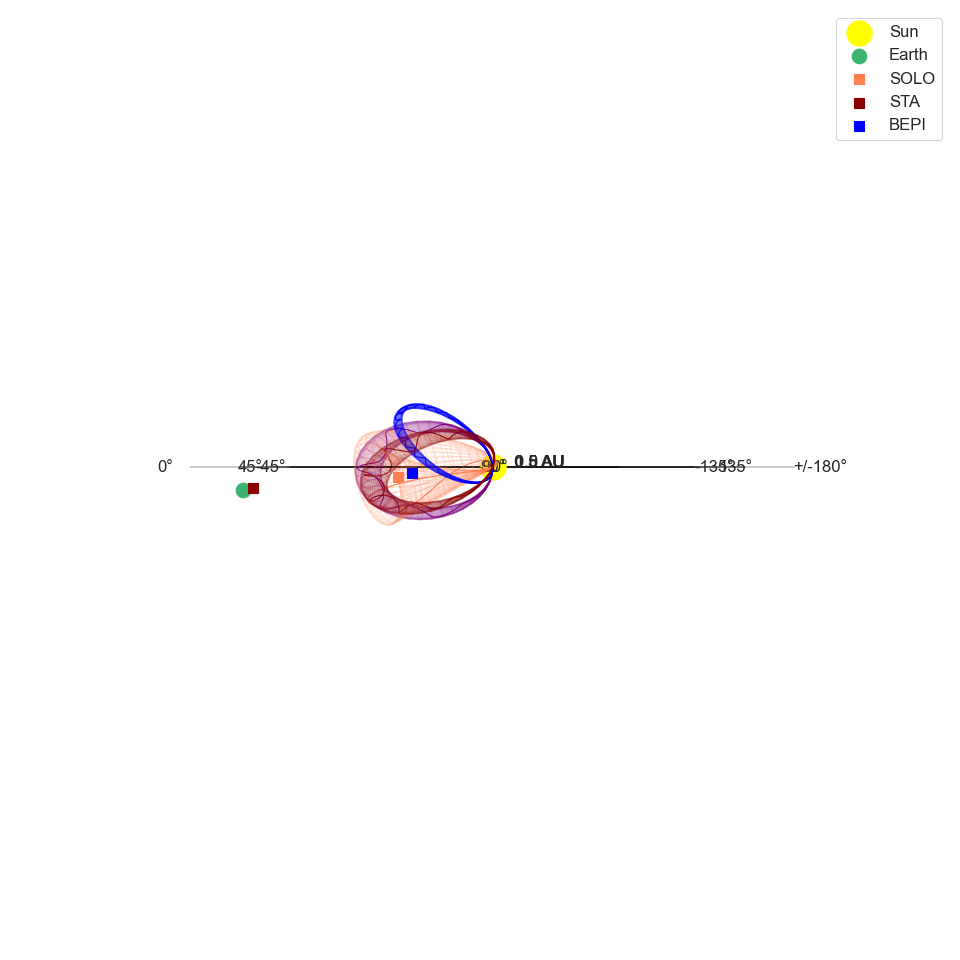

Saved 3D snapshot with azim 90, elev 0, radius 1.2


In [63]:
plot_configs = [
    [0, 90, 1.2],
    [0, 0, 1.2],
    [90, 0, 1.2]
]

save_3d_results_plot = True

for plot_config in plot_configs:

    fig, ax = plot_3d_results(
        data_caches=[
            data_cache_solo,
            data_cache_sta,
            data_cache_bepi,
            data_cache_wind
        ], 
        t_snap=t_snap, 
        spacecraft=spacecraft, 
        planets=planets, 
        t_launch=t_launch,
        view_azim = plot_config[0],
        view_elev = plot_config[1],
        view_radius=plot_config[2]
    )
    plt.show()

    if save_3d_results_plot:
        fig.savefig(output_path / f"{t_snap.strftime("%Y-%m-%dT%H:%M")}_3d_snapshot_azim{plot_config[0]}_elev{plot_config[1]}_rad{plot_config[2]}.png", dpi=200)

        print(f"Saved 3D snapshot with azim {plot_config[0]}, elev {plot_config[1]}, radius {plot_config[2]}")
        